# OpenCL Thread Coarsening

This notebook contains the experiments for Case Study B - using deep learning to predict thread coarsening factor for OpenCL kernels, without hand engineered features.

## 1. Runtime Data

We use author-provided runtime data from the PACT'14 paper that we compare against [1].

> [1] Magni, A., Dubach, C., & O’Boyle, M. (2014). [Automatic Optimization of Thread-Coarsening for Graphics Processors](http://www.research.ed.ac.uk/portal/files/19958629/magni14pact.pdf). In PACT. ACM.

The data consists of runtimes from 17 benchmarks accross 4 experimental platforms:

In [1]:
import pandas as pd
pd.set_option('display.max_rows', 5)

df = pd.read_csv("../data/case-study-b/pact-2014-runtimes.csv")
df

,kernel,cf,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,runtime_Fermi,runtime_Kepler,runtime_Cypress,runtime_Tahiti,src,seq
0,blackscholes,1,1.994918,-0.810402,-2.206370,3.217486,-2.193143,2.374925,0.174607,1321696.0,1381120.0,1783889.0,975555.0,"__kernel void A(__global float* a, __global fl...",[ 59 1 118 1 31 7 58 1 80 9 1 ...
1,blackscholes,2,2.133716,-1.493068,-1.286520,3.075195,-0.381715,0.677804,0.960159,1238176.0,1222336.0,1849444.0,962963.0,"__kernel void A(__global float* a, __global fl...",[ 59 1 118 1 31 7 58 1 80 9 1 ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,nbody,8,-1.753095,-0.428577,-4.534866,-1.279360,0.941490,1.106185,-0.531706,332913280.0,30859456.0,35734111.0,36427408.0,"__kernel void A(__global float4* a, __global f...",[ 59 1 118 1 31 7 58 1 80 19 9 ...
88,nbody,16,-4.279616,-1.328454,-6.529448,-1.415595,2.290164,-0.138573,0.294633,NaN,NaN,42521556.0,65451704.0,"__kernel void A(__global float4* a, __global f...",[ 59 1 118 1 31 7 58 1 80 19 9 ...


From this we can derive the "oracle" thread coarsening factors, i.e. the thread coarsening factors which provided the lowest runtime on each of the four architectures, for each of the 17 benchmarks:

In [2]:
oracles = pd.read_csv("../data/case-study-b/pact-2014-oracles.csv")
oracles

,kernel,cf_Fermi,runtime_Fermi,cf_Kepler,runtime_Kepler,cf_Cypress,runtime_Cypress,cf_Tahiti,runtime_Tahiti
0,binarySearch,1.0,213216.0,16.0,165248.0,2.0,290889.0,4.0,178518.0
1,blackscholes,8.0,1148128.0,4.0,1179008.0,1.0,1783889.0,2.0,962963.0
...,...,...,...,...,...,...,...,...,...
15,spmv,1.0,36224.0,1.0,52896.0,1.0,82000.0,1.0,64592.0
16,stencil,2.0,4295104.0,1.0,4330912.0,1.0,10420555.0,1.0,5200148.0


## 2. Predictive Models

We define a base class for implementing predictive models for thread coarsening:

In [3]:
import numpy as np
from clgen import _atomizer as clgen

class ThreadCoarseningModel(object):
    """
    A model for predicting OpenCL thread coarsening factors.

    Attributes
    ----------
    __name__ : str
        Model name
    __basename__ : str
        Shortened name, used for files
    """
    __name__ = None
    __basename__ = None

    def init(self, seed: int) -> None:
        """
        Initialize the model.

        Do whatever is required to setup a new thread coarsening model here.
        This method is called prior to training and predicting.
        This method may be omitted if no initial setup is required.

        Parameters
        ----------
        seed : int
            The seed value used to reproducible results. May be 'None',
            indicating that no seed is to be used.
        """
        pass

    def save(self, outpath: str) -> None:
        """
        Save model state.

        This must capture all of the relevant state of the model. It is up
        to implementing classes to determine how best to save the model.

        Parameters
        ----------
        outpath : str
            The path to save the model state to.
        """
        raise NotImplementedError

    def restore(self, inpath: str) -> None:
        """
        Load a trained model from file.

        This is called in place of init() if a saved model file exists. It
        must restore all of the required model state.

        Parameters
        ----------
        inpath : str
            The path to load the model from. This is the same path as
            was passed to save() to create the file.
        """
        raise NotImplementedError

    def train(self, cascading_features: np.array, cascading_y: np.array,
              sequences: np.array, y_1hot: np.array, verbose: bool=False) -> None:
        """
        Train a model.

        Parameters
        ----------
        cascading_features : np.array
            An array of feature vectors of shape (n,7,7). Used for the cascading
            model, there are 7 vectors of 7 features for each benchmark, one for
            each coarsening factor.

        cascading_y : np.array
            An array of classification labels of shape(n,7). Used for the cascading
            model.

        sequences : np.array
            An array of encoded source code sequences of shape (n,seq_length).

        y_1hot : np.array
            An array of optimal coarsening factors of shape (n,6), in 1-hot encoding.

        verbose: bool, optional
            Whether to print verbose status messages during training.
        """
        raise NotImplementedError

    def predict(self, cascading_features: np.array, sequences: np.array) -> np.array:
        """
        Make predictions for programs.

        Parameters
        ----------
        cascading_features : np.array
            An array of feature vectors of shape (n,7,7). Used for the cascading
            model, there are 7 vectors of 7 features for each benchmark, one for
            each coarsening factor.

        sequences : np.array
            An array of encoded source code sequences of shape (n,seq_length).

        Returns
        -------
        np.array
            Predicted 'y' values (optimal thread coarsening factors) with shape (n,1).
        """
        raise NotImplementedError


/home/elandg/eecs583-paper-end2end-dl/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/elandg/eecs583-paper-end2end-dl/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/elandg/eecs583-paper-end2end-dl/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/elandg/eecs583-pape

We also define some utility code which we will use later:

In [4]:
cfs = [1, 2, 4, 8, 16, 32]  # thread coarsening factors

def get_onehot(df, platform):
    hot = np.zeros((len(df), len(cfs)), dtype=np.int32)
    for i, cf in enumerate(df[f"cf_{platform}"]):
        hot[i][cfs.index(cf)] = 1

    return hot


def get_magni_features(df, oracles, platform):
    """
    Assemble cascading data.
    """
    X_cc, y_cc, = [], []
    for kernel in sorted(set(df["kernel"])):
        _df = df[df["kernel"] == kernel]

        oracle_cf = int(oracles[oracles["kernel"] == kernel][f"cf_{platform}"].values[0])

        feature_vectors = np.asarray([
            _df['PCA1'].values,
            _df['PCA2'].values,
            _df['PCA3'].values,
            _df['PCA4'].values,
            _df['PCA5'].values,
            _df['PCA6'].values,
            _df['PCA7'].values,
        ]).T
                
        X_cc.append(feature_vectors)
        y = []
        cfs__ = []
        for i, cf in enumerate(cfs[:len(feature_vectors)]):
            y_ = 1 if cf < oracle_cf else 0
            y.append(y_)
        y_cc.append(y)
    
        assert len(feature_vectors) == len(y)
        
    assert len(X_cc) == len(y_cc) == 17
    
    return np.asarray(X_cc), np.asarray(y_cc)


def encode_srcs(srcs):
    """ encode and pad source code for learning """
    from keras.preprocessing.sequence import pad_sequences
    
    seqs = [atomizer.atomize(src) for src in srcs]
    pad_val = atomizer.vocab_size
    encoded = np.array(pad_sequences(seqs, maxlen=1024, value=pad_val))
    return np.vstack([np.expand_dims(x, axis=0) for x in encoded])


def platform2str(platform):
    if platform == "Fermi":
        return "NVIDIA GTX 480"
    elif platform == "Kepler":
        return "NVIDIA Tesla K20c"
    elif platform == "Cypress":
        return "AMD Radeon HD 5900"
    elif platform == "Tahiti":
        return "AMD Tahiti 7970"
    else:
        raise LookupError

## 3. Experimental Methodology

For reproducible results:

In [5]:
seed = 204

The source encoder (see the *'Language Model.ipynb'* notebook for details):

In [6]:
from clgen import Language

srcs = '\n'.join(pd.read_csv("../data/case-study-a/cgo17-amd.csv")['src'].values)
atomizer = clgen.GreedyAtomizer.from_text(lang=Language.from_str("opencl"), text=srcs)
atomizer

GreedyAtomizer[128 tokens]

In [7]:
import pickle
import sys
from labm8 import fs
from sklearn.model_selection import KFold, train_test_split

def evaluate(model):
    # report progress:
    from progressbar import ProgressBar
    progressbar = [0, ProgressBar(max_value=68)]
    
    data = []
    
    X_seq = None  # defer sequence encoding (it's expensive)
    
    for i, platform in enumerate(["Cypress", "Tahiti", "Fermi", "Kepler"]):
        platform_name = platform2str(platform)
                
        # load data
        oracle_runtimes = np.array([float(x) for x in oracles["runtime_" + platform]])
        y = np.array([int(x) for x in oracles["cf_" + platform]], dtype=np.int32)
        y_1hot = get_onehot(oracles, platform)
        X_cc, y_cc = get_magni_features(df, oracles, platform)
        
        # LOOCV
        kf = KFold(n_splits=len(y), shuffle=False)
    
        for j, (train_index, test_index) in enumerate(kf.split(y)):
        # indices = np.arange(len(y))
        # train_index, test_index = train_test_split(indices, shuffle=True, random_state=seed, test_size=0.25)
            kernel = sorted(set(df["kernel"]))[test_index[0]]

            model_name = model.__name__
            model_basename = model.__basename__
            
            model_path = f"../data/case-study-b/models/{model_basename}-{platform}.model"
            predictions_path = f"../data/case-study-b/predictions/{model_basename}-{platform}.result"  

            if False:
            # if fs.exists(predictions_path):
                # load result from cache
                with open(predictions_path, 'rb') as infile:
                    p = pickle.load(infile)
            else:
                if False:
                # if fs.exists(model_path):
                    # load a trained model from cache
                    model.restore(model_path)
                else:
                    # encode source codes
                    if X_seq is None:
                        X_seq = encode_srcs(df["src"].values)

                    # create a new model and train it
                    model.init(seed=seed)
                    model.train(cascading_features=np.concatenate(X_cc[train_index]),
                                cascading_y=np.concatenate(y_cc[train_index]),
                                sequences=X_seq[train_index],
                                verbose=True, # TODO
                                y_1hot=y_1hot[train_index])

                    # cache the model
                    fs.mkdir(fs.dirname(model_path))
                    model.save(model_path)

                # make prediction
                p = model.predict(cascading_features=X_cc[test_index[0]], sequences=X_seq[test_index])[0]
                p = min(p, 2 ** (len(X_cc[test_index[0]]) - 1))
                
                # cache the prediction
                fs.mkdir(fs.dirname(predictions_path))
                with open(predictions_path, 'wb') as outfile:
                    pickle.dump(p, outfile)
                    
            # oracle prediction
            o = y[test_index[0]]
            correct = p == o

            # get runtime without thread coarsening
            row = df[(df["kernel"] == kernel) & (df["cf"] == 1)]
            assert(len(row) == 1)  # sanity check
            nocf_runtime = float(row["runtime_" + platform])

            # get runtime of prediction
            row = df[(df["kernel"] == kernel) & (df["cf"] == p)]
            assert(len(row) == 1)  # sanity check
            p_runtime = float(row["runtime_" + platform])
            
            # get runtime of oracle coarsening factor
            o_runtime = oracle_runtimes[test_index[0]]

            # speedup and % oracle
            s_oracle = nocf_runtime / o_runtime
            p_speedup = nocf_runtime / p_runtime
            p_oracle = o_runtime / p_runtime

            # record result
            data.append({
                "Model": model_name,
                "Platform": platform_name,
                "Kernel": kernel,
                "Oracle-CF": o,
                "Predicted-CF": p,
                "Speedup": p_speedup,
                "Oracle": p_oracle
            })
            
            progressbar[0] += 1  # update progress bar
            progressbar[1].update(progressbar[0])

    return pd.DataFrame(data, columns=[
        "Model", "Platform", "Kernel", "Oracle-CF", "Predicted-CF", "Speedup", "Oracle"])

### 3.1. Magni et al. Model

The Magni et al. predictive model.

Described in publication:

> [1] Magni, A., Dubach, C., & O’Boyle, M. (2014). [Automatic Optimization of Thread-Coarsening for Graphics Processors](http://www.research.ed.ac.uk/portal/files/19958629/magni14pact.pdf). In PACT. ACM.

In [8]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, KFold

# during grid search, not all parameters will converge. Ignore these warnings
from warnings import filterwarnings
from sklearn.exceptions import ConvergenceWarning
filterwarnings("ignore", category=ConvergenceWarning)

class Magni(ThreadCoarseningModel):
    __name__ = "Magni et al."
    __basename__ = "magni"

    def init(self, seed: int=None):
        # the neural network
        nn = MLPClassifier(random_state=seed, shuffle=True)

        # cross-validation over the training set. We train on 16 programs,
        # so with k=16 and no shuffling of the data, we're performing
        # nested leave-one-out cross-validation
        inner_cv = KFold(n_splits=16, shuffle=False)

        # hyper-parameter combinations to try
        params = {
            "max_iter": [200, 500, 1000, 2000],
            "hidden_layer_sizes": [
                (32,),
                (32, 32),
                (32, 32, 32),
                (64,),
                (64, 64),
                (64, 64, 64),
                (128,),
                (128, 128),
                (128, 128, 128),
                (256,),
                (256, 256),
                (256, 256, 256),
            ]
        }

        self.model = GridSearchCV(nn, cv=inner_cv, param_grid=params, n_jobs=-1)

    def save(self, outpath):
        with open(outpath, 'wb') as outfile:
            pickle.dump(self.model, outfile)

    def restore(self, inpath):
        with open(inpath, 'rb') as infile:
            self.model = pickle.load(infile)

    def train(self, cascading_features: np.array, cascading_y: np.array,
              sequences: np.array, y_1hot: np.array, verbose: bool=False) -> None:
        self.model.fit(cascading_features, cascading_y)

    def predict(self, cascading_features: np.array, sequences: np.array) -> np.array:
        # we only support leave-one-out cross-validation (implementation detail):
        assert(len(sequences) == 1)

        # The binary cascading model:
        #
        # iteratively apply thread coarsening, using a new feature vector
        # every time coarsening is applied
        for i in range(len(cascading_features)):
            # predict whether to coarsen, using the program features of
            # the current coarsening level:
            should_coarsen = self.model.predict([cascading_features[i]])[0]
            if not should_coarsen:
                break
        p = cfs[i]
        return [cfs[i]]


In [9]:
# print("Evaluating Magni et al. ...", file=sys.stderr)
# magni = evaluate(Magni())
# magni.groupby('Platform')['Platform', 'Speedup', 'Oracle'].mean()

### 3.2. DeepTune

We predict thread coarsening factor directly from raw source code inputs:

In [10]:
class DeepTune(ThreadCoarseningModel):
    __name__ = "DeepTune"
    __basename__ = "deeptune"

    def init(self, seed: int=None):
        from keras.layers import Input, Embedding, LSTM, Dense, Conv1D, GlobalMaxPooling1D
        from keras.layers.normalization import BatchNormalization
        from keras.models import Model, Sequential, load_model
    
        np.random.seed(seed)
    
        # Vocabulary has a padding character
        vocab_size = atomizer.vocab_size + 1

        # Language model. Takes as inputs source code sequences.
        seq_inputs = Input(shape=(1024,), dtype="int32")
        x = Embedding(input_dim=vocab_size, input_length=1024,
                      output_dim=64, name="embedding")(seq_inputs)
        # x = LSTM(64, return_sequences=True, implementation=1, name="lstm_1")(x)
        # x = LSTM(64, implementation=1, name="lstm_2")(x)
        x = Conv1D(32, 9, name="conv_1")(x)
        x = Conv1D(32, 9, name="conv_2")(x)
        x = GlobalMaxPooling1D()(x)
        
        # Heuristic model. Takes as inputs the language model,
        #   outputs 1-of-6 thread coarsening factor
        x = BatchNormalization()(x)
        x = Dense(32, activation="relu")(x)
        outputs = Dense(6, activation="sigmoid")(x)

        self.model = Model(inputs=seq_inputs, outputs=outputs)
        self.model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])

    def save(self, outpath: str):
        self.model.save(outpath)

    def restore(self, inpath: str):
        self.model = load_model(inpath)
        
    def train(self, cascading_features: np.array, cascading_y: np.array,
              sequences: np.array, y_1hot: np.array, verbose: bool=False) -> None:
        self.model.fit(sequences, y_1hot, epochs=50, batch_size=64, verbose=verbose, shuffle=True)

    def predict(self, cascading_features: np.array, sequences: np.array) -> np.array:
        # directly predict optimal thread coarsening factor from source sequences:
        p = np.array(self.model.predict(sequences, batch_size=64, verbose=0))
        indices = [np.argmax(x) for x in p]
        return [cfs[x] for x in indices]

An overview of the DeepTune model, showing the number of parameters in each layer, used to construct Table 5 in the paper:

In [11]:
deeptune_model = DeepTune()
deeptune_model.init(seed)
deeptune_model.model.summary()

Using TensorFlow backend.




Instructions for updating:
keep_dims is deprecated, use keepdims instead

Instructions for updating:
keep_dims is deprecated, use keepdims instead

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1024)              0         
_________________________________________________________________
embedding (Embedding)        (None, 1024, 64)          8256      
_________________________________________________________________
conv_1 (Conv1D)              (None, 1016, 32)          18464     
_________________________________________________________________
conv_2 (Conv1D)              (None, 1008, 32)          9248      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128

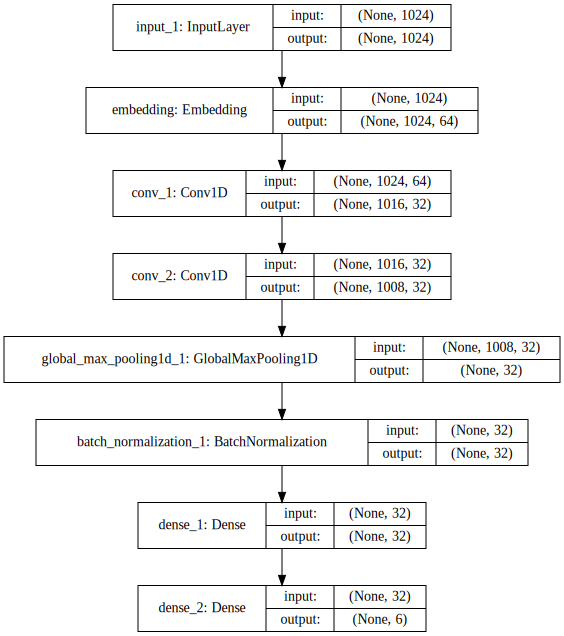

In [12]:
def isnotebook():
    # written by @mtd http://stackoverflow.com/a/39662359
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':  # Jupyter notebook or qtconsole?
            return True
        elif shell == 'TerminalInteractiveShell':  # Terminal running IPython?
            return False
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter


img = None
if isnotebook():
    from keras.utils.vis_utils import model_to_dot
    from IPython.display import SVG
    img = SVG(model_to_dot(deeptune_model.model, show_shapes=True).create(prog='dot', format='svg'))
img

Summary of results:

In [13]:
print("Evaluating DeepTune ...", file=sys.stderr)
deeptune = evaluate(DeepTune())
deeptune.groupby('Platform')['Platform', 'Speedup', 'Oracle'].mean()

Evaluating DeepTune ...
/home/elandg/eecs583-paper-end2end-dl/env/lib/python3.7/site-packages/ipykernel_launcher.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Epoch 1/50


2022-12-14 11:28:40.980963: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-12-14 11:28:41.015051: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2808000000 Hz
2022-12-14 11:28:41.018379: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x64e67f0 executing computations on platform Host. Devices:
2022-12-14 11:28:41.018473: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2022-12-14 11:28:43.363364: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1412] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not via TF_XLA_FLAGS) or se

16/16 [==============================] - 5s 327ms/step - loss: 1.7890 - acc: 0.1250
Epoch 2/50
16/16 [==============================] - 0s 13ms/step - loss: 1.7201 - acc: 0.3125
Epoch 3/50
16/16 [==============================] - 0s 22ms/step - loss: 1.6741 - acc: 0.3125
Epoch 4/50
16/16 [==============================] - 0s 15ms/step - loss: 1.6487 - acc: 0.3125
Epoch 5/50
16/16 [==============================] - 0s 16ms/step - loss: 1.6283 - acc: 0.3125
Epoch 6/50
16/16 [==============================] - 0s 14ms/step - loss: 1.6157 - acc: 0.3125
Epoch 7/50
16/16 [==============================] - 0s 17ms/step - loss: 1.6017 - acc: 0.3125
Epoch 8/50
16/16 [==============================] - 0s 15ms/step - loss: 1.5923 - acc: 0.3125
Epoch 9/50
16/16 [==============================] - 0s 14ms/step - loss: 1.5837 - acc: 0.3125
Epoch 10/50
16/16 [==============================] - 0s 16ms/step - loss: 1.5764 - acc: 0.3125
Epoch 11/50
16/16 [==============================] - 0s 18ms/step - l

  0% (0 of 68) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

Epoch 1/50
16/16 [==============================] - 5s 284ms/step - loss: 1.7902 - acc: 0.1250
Epoch 2/50
16/16 [==============================] - 0s 21ms/step - loss: 1.7446 - acc: 0.1875
Epoch 3/50
16/16 [==============================] - 0s 12ms/step - loss: 1.6914 - acc: 0.3750
Epoch 4/50
16/16 [==============================] - 0s 20ms/step - loss: 1.6608 - acc: 0.3750
Epoch 5/50
16/16 [==============================] - 0s 20ms/step - loss: 1.6326 - acc: 0.3750
Epoch 6/50
16/16 [==============================] - 0s 19ms/step - loss: 1.6113 - acc: 0.3750
Epoch 7/50
16/16 [==============================] - 0s 19ms/step - loss: 1.5907 - acc: 0.3750
Epoch 8/50
16/16 [==============================] - 0s 23ms/step - loss: 1.5703 - acc: 0.4375
Epoch 9/50
16/16 [==============================] - 0s 22ms/step - loss: 1.5539 - acc: 0.4375
Epoch 10/50
16/16 [==============================] - 0s 19ms/step - loss: 1.5399 - acc: 0.4375
Epoch 11/50
16/16 [==============================] - 0s 24

  2% (2 of 68) |                         | Elapsed Time: 0:00:29 ETA:   0:16:19

Epoch 1/50
16/16 [==============================] - 4s 280ms/step - loss: 1.7890 - acc: 0.1250
Epoch 2/50
16/16 [==============================] - 0s 13ms/step - loss: 1.7112 - acc: 0.3125
Epoch 3/50
16/16 [==============================] - 0s 17ms/step - loss: 1.6687 - acc: 0.3125
Epoch 4/50
16/16 [==============================] - 0s 19ms/step - loss: 1.6434 - acc: 0.3125
Epoch 5/50
16/16 [==============================] - 0s 18ms/step - loss: 1.6247 - acc: 0.3125
Epoch 6/50
16/16 [==============================] - 0s 26ms/step - loss: 1.6121 - acc: 0.3125
Epoch 7/50
16/16 [==============================] - 0s 29ms/step - loss: 1.6005 - acc: 0.3125
Epoch 8/50
16/16 [==============================] - 0s 24ms/step - loss: 1.5902 - acc: 0.3125
Epoch 9/50
16/16 [==============================] - 0s 27ms/step - loss: 1.5810 - acc: 0.3125
Epoch 10/50
16/16 [==============================] - 0s 28ms/step - loss: 1.5748 - acc: 0.3125
Epoch 11/50
16/16 [==============================] - 0s 25

  4% (3 of 68) |#                        | Elapsed Time: 0:01:07 ETA:   0:41:22

Epoch 1/50
16/16 [==============================] - 6s 390ms/step - loss: 1.7997 - acc: 0.1250
Epoch 2/50
16/16 [==============================] - 0s 12ms/step - loss: 1.7167 - acc: 0.1875
Epoch 3/50
16/16 [==============================] - 0s 18ms/step - loss: 1.6589 - acc: 0.4375
Epoch 4/50
16/16 [==============================] - 0s 22ms/step - loss: 1.6138 - acc: 0.4375
Epoch 5/50
16/16 [==============================] - 0s 16ms/step - loss: 1.5834 - acc: 0.4375
Epoch 6/50
16/16 [==============================] - 0s 19ms/step - loss: 1.5655 - acc: 0.4375
Epoch 7/50
16/16 [==============================] - 0s 16ms/step - loss: 1.5506 - acc: 0.4375
Epoch 8/50
16/16 [==============================] - 0s 19ms/step - loss: 1.5359 - acc: 0.4375
Epoch 9/50
16/16 [==============================] - 0s 16ms/step - loss: 1.5235 - acc: 0.4375
Epoch 10/50
16/16 [==============================] - 0s 21ms/step - loss: 1.5124 - acc: 0.4375
Epoch 11/50
16/16 [==============================] - 0s 20

  5% (4 of 68) |#                        | Elapsed Time: 0:01:42 ETA:   0:36:45

Epoch 1/50
16/16 [==============================] - 7s 422ms/step - loss: 1.7918 - acc: 0.0625
Epoch 2/50
16/16 [==============================] - 0s 13ms/step - loss: 1.7150 - acc: 0.1875
Epoch 3/50
16/16 [==============================] - 0s 14ms/step - loss: 1.6653 - acc: 0.3750
Epoch 4/50
16/16 [==============================] - 0s 17ms/step - loss: 1.6343 - acc: 0.3750
Epoch 5/50
16/16 [==============================] - 0s 21ms/step - loss: 1.6117 - acc: 0.3750
Epoch 6/50
16/16 [==============================] - 0s 17ms/step - loss: 1.5995 - acc: 0.3750
Epoch 7/50
16/16 [==============================] - 0s 18ms/step - loss: 1.5846 - acc: 0.3750
Epoch 8/50
16/16 [==============================] - 0s 18ms/step - loss: 1.5735 - acc: 0.3750
Epoch 9/50
16/16 [==============================] - 0s 14ms/step - loss: 1.5616 - acc: 0.3750
Epoch 10/50
16/16 [==============================] - 0s 17ms/step - loss: 1.5513 - acc: 0.3750
Epoch 11/50
16/16 [==============================] - 0s 12

  7% (5 of 68) |#                        | Elapsed Time: 0:02:16 ETA:   0:35:53

Epoch 1/50
16/16 [==============================] - 6s 366ms/step - loss: 1.7894 - acc: 0.1250
Epoch 2/50
16/16 [==============================] - 0s 12ms/step - loss: 1.7184 - acc: 0.1875
Epoch 3/50
16/16 [==============================] - 0s 17ms/step - loss: 1.6727 - acc: 0.3125
Epoch 4/50
16/16 [==============================] - 0s 19ms/step - loss: 1.6436 - acc: 0.3125
Epoch 5/50
16/16 [==============================] - 0s 21ms/step - loss: 1.6249 - acc: 0.3125
Epoch 6/50
16/16 [==============================] - 0s 23ms/step - loss: 1.6092 - acc: 0.3125
Epoch 7/50
16/16 [==============================] - 0s 26ms/step - loss: 1.6005 - acc: 0.3125
Epoch 8/50
16/16 [==============================] - 0s 16ms/step - loss: 1.5888 - acc: 0.3125
Epoch 9/50
16/16 [==============================] - 0s 15ms/step - loss: 1.5771 - acc: 0.3125
Epoch 10/50
16/16 [==============================] - 0s 20ms/step - loss: 1.5697 - acc: 0.3125
Epoch 11/50
16/16 [==============================] - 0s 16

  8% (6 of 68) |##                       | Elapsed Time: 0:02:46 ETA:   0:31:23

Epoch 1/50
16/16 [==============================] - 6s 386ms/step - loss: 1.7894 - acc: 0.1250
Epoch 2/50
16/16 [==============================] - 0s 18ms/step - loss: 1.7264 - acc: 0.3750
Epoch 3/50
16/16 [==============================] - 0s 21ms/step - loss: 1.6736 - acc: 0.3125
Epoch 4/50
16/16 [==============================] - 0s 19ms/step - loss: 1.6447 - acc: 0.3125
Epoch 5/50
16/16 [==============================] - 0s 17ms/step - loss: 1.6264 - acc: 0.3125
Epoch 6/50
16/16 [==============================] - 0s 20ms/step - loss: 1.6132 - acc: 0.3125
Epoch 7/50
16/16 [==============================] - 0s 15ms/step - loss: 1.6003 - acc: 0.3125
Epoch 8/50
16/16 [==============================] - 0s 23ms/step - loss: 1.5890 - acc: 0.3125
Epoch 9/50
16/16 [==============================] - 0s 16ms/step - loss: 1.5782 - acc: 0.3125
Epoch 10/50
16/16 [==============================] - 0s 17ms/step - loss: 1.5705 - acc: 0.3125
Epoch 11/50
16/16 [==============================] - 0s 14

 10% (7 of 68) |##                       | Elapsed Time: 0:03:20 ETA:   0:33:52

Epoch 1/50
16/16 [==============================] - 9s 536ms/step - loss: 1.7894 - acc: 0.1250
Epoch 2/50
16/16 [==============================] - 0s 15ms/step - loss: 1.7264 - acc: 0.3750
Epoch 3/50
16/16 [==============================] - 0s 27ms/step - loss: 1.6736 - acc: 0.3125
Epoch 4/50
16/16 [==============================] - 0s 19ms/step - loss: 1.6449 - acc: 0.3125
Epoch 5/50
16/16 [==============================] - 0s 16ms/step - loss: 1.6254 - acc: 0.3125
Epoch 6/50
16/16 [==============================] - 0s 23ms/step - loss: 1.6129 - acc: 0.3125
Epoch 7/50
16/16 [==============================] - 0s 19ms/step - loss: 1.5999 - acc: 0.3125
Epoch 8/50
16/16 [==============================] - 0s 16ms/step - loss: 1.5889 - acc: 0.3125
Epoch 9/50
16/16 [==============================] - 0s 15ms/step - loss: 1.5788 - acc: 0.3125
Epoch 10/50
16/16 [==============================] - 0s 18ms/step - loss: 1.5706 - acc: 0.3125
Epoch 11/50
16/16 [==============================] - 0s 17

 11% (8 of 68) |##                       | Elapsed Time: 0:03:57 ETA:   0:37:03

Epoch 1/50
16/16 [==============================] - 7s 451ms/step - loss: 1.7857 - acc: 0.1250
Epoch 2/50
16/16 [==============================] - 0s 19ms/step - loss: 1.6981 - acc: 0.3750
Epoch 3/50
16/16 [==============================] - 0s 23ms/step - loss: 1.6399 - acc: 0.3750
Epoch 4/50
16/16 [==============================] - 0s 31ms/step - loss: 1.6017 - acc: 0.3125
Epoch 5/50
16/16 [==============================] - 1s 33ms/step - loss: 1.5783 - acc: 0.3125
Epoch 6/50
16/16 [==============================] - 0s 23ms/step - loss: 1.5605 - acc: 0.3125
Epoch 7/50
16/16 [==============================] - 1s 31ms/step - loss: 1.5466 - acc: 0.3125
Epoch 8/50
16/16 [==============================] - 0s 25ms/step - loss: 1.5318 - acc: 0.3125
Epoch 9/50
16/16 [==============================] - 0s 22ms/step - loss: 1.5192 - acc: 0.3125
Epoch 10/50
16/16 [==============================] - 0s 20ms/step - loss: 1.5103 - acc: 0.3125
Epoch 11/50
16/16 [==============================] - 0s 21

 13% (9 of 68) |###                      | Elapsed Time: 0:04:32 ETA:   0:35:07

Epoch 1/50
16/16 [==============================] - 7s 461ms/step - loss: 1.7911 - acc: 0.1250
Epoch 2/50
16/16 [==============================] - 0s 14ms/step - loss: 1.7151 - acc: 0.4375
Epoch 3/50
16/16 [==============================] - 0s 14ms/step - loss: 1.6655 - acc: 0.3750
Epoch 4/50
16/16 [==============================] - 0s 14ms/step - loss: 1.6301 - acc: 0.3750
Epoch 5/50
16/16 [==============================] - 0s 22ms/step - loss: 1.6071 - acc: 0.3750
Epoch 6/50
16/16 [==============================] - 0s 24ms/step - loss: 1.5909 - acc: 0.3750
Epoch 7/50
16/16 [==============================] - 0s 24ms/step - loss: 1.5776 - acc: 0.3750
Epoch 8/50
16/16 [==============================] - 1s 33ms/step - loss: 1.5652 - acc: 0.3750
Epoch 9/50
16/16 [==============================] - 0s 18ms/step - loss: 1.5540 - acc: 0.3125
Epoch 10/50
16/16 [==============================] - 0s 21ms/step - loss: 1.5437 - acc: 0.3125
Epoch 11/50
16/16 [==============================] - 0s 22

 14% (10 of 68) |###                     | Elapsed Time: 0:05:09 ETA:   0:34:56

Epoch 1/50
16/16 [==============================] - 7s 446ms/step - loss: 1.7910 - acc: 0.1250
Epoch 2/50
16/16 [==============================] - 0s 12ms/step - loss: 1.7306 - acc: 0.4375
Epoch 3/50
16/16 [==============================] - 0s 11ms/step - loss: 1.6784 - acc: 0.3750
Epoch 4/50
16/16 [==============================] - 0s 15ms/step - loss: 1.6472 - acc: 0.3750
Epoch 5/50
16/16 [==============================] - 0s 14ms/step - loss: 1.6254 - acc: 0.3750
Epoch 6/50
16/16 [==============================] - 0s 16ms/step - loss: 1.6103 - acc: 0.3750
Epoch 7/50
16/16 [==============================] - 0s 15ms/step - loss: 1.5982 - acc: 0.3750
Epoch 8/50
16/16 [==============================] - 0s 16ms/step - loss: 1.5876 - acc: 0.3750
Epoch 9/50
16/16 [==============================] - 0s 13ms/step - loss: 1.5783 - acc: 0.3750
Epoch 10/50
16/16 [==============================] - 0s 19ms/step - loss: 1.5699 - acc: 0.3750
Epoch 11/50
16/16 [==============================] - 0s 15

 16% (11 of 68) |###                     | Elapsed Time: 0:05:46 ETA:   0:35:44

Epoch 1/50
16/16 [==============================] - 9s 585ms/step - loss: 1.7910 - acc: 0.1250
Epoch 2/50
16/16 [==============================] - 0s 14ms/step - loss: 1.7208 - acc: 0.4375
Epoch 3/50
16/16 [==============================] - 0s 11ms/step - loss: 1.6707 - acc: 0.3750
Epoch 4/50
16/16 [==============================] - 0s 16ms/step - loss: 1.6408 - acc: 0.3750
Epoch 5/50
16/16 [==============================] - 0s 12ms/step - loss: 1.6206 - acc: 0.3750
Epoch 6/50
16/16 [==============================] - 0s 14ms/step - loss: 1.6051 - acc: 0.3750
Epoch 7/50
16/16 [==============================] - 0s 12ms/step - loss: 1.5944 - acc: 0.3750
Epoch 8/50
16/16 [==============================] - 0s 13ms/step - loss: 1.5845 - acc: 0.3750
Epoch 9/50
16/16 [==============================] - 0s 12ms/step - loss: 1.5752 - acc: 0.3750
Epoch 10/50
16/16 [==============================] - 0s 12ms/step - loss: 1.5676 - acc: 0.3750
Epoch 11/50
16/16 [==============================] - 0s 13

 17% (12 of 68) |####                    | Elapsed Time: 0:06:26 ETA:   0:36:37

Epoch 1/50
16/16 [==============================] - 8s 498ms/step - loss: 1.7918 - acc: 0.0625
Epoch 2/50
16/16 [==============================] - 0s 12ms/step - loss: 1.7146 - acc: 0.1875
Epoch 3/50
16/16 [==============================] - 0s 13ms/step - loss: 1.6647 - acc: 0.3750
Epoch 4/50
16/16 [==============================] - 0s 11ms/step - loss: 1.6339 - acc: 0.3750
Epoch 5/50
16/16 [==============================] - 0s 13ms/step - loss: 1.6129 - acc: 0.3750
Epoch 6/50
16/16 [==============================] - 0s 11ms/step - loss: 1.5997 - acc: 0.3750
Epoch 7/50
16/16 [==============================] - 0s 12ms/step - loss: 1.5860 - acc: 0.3750
Epoch 8/50
16/16 [==============================] - 0s 12ms/step - loss: 1.5756 - acc: 0.3750
Epoch 9/50
16/16 [==============================] - 0s 13ms/step - loss: 1.5629 - acc: 0.3750
Epoch 10/50
16/16 [==============================] - 0s 11ms/step - loss: 1.5520 - acc: 0.3125
Epoch 11/50
16/16 [==============================] - 0s 14

 19% (13 of 68) |####                    | Elapsed Time: 0:07:00 ETA:   0:31:39

Epoch 1/50
16/16 [==============================] - 12s 736ms/step - loss: 1.7910 - acc: 0.1250
Epoch 2/50
16/16 [==============================] - 0s 18ms/step - loss: 1.7306 - acc: 0.4375
Epoch 3/50
16/16 [==============================] - 0s 16ms/step - loss: 1.6784 - acc: 0.3750
Epoch 4/50
16/16 [==============================] - 0s 21ms/step - loss: 1.6490 - acc: 0.3750
Epoch 5/50
16/16 [==============================] - 0s 20ms/step - loss: 1.6264 - acc: 0.3750
Epoch 6/50
16/16 [==============================] - 0s 18ms/step - loss: 1.6114 - acc: 0.3750
Epoch 7/50
16/16 [==============================] - 0s 20ms/step - loss: 1.5986 - acc: 0.3750
Epoch 8/50
16/16 [==============================] - 0s 27ms/step - loss: 1.5878 - acc: 0.3750
Epoch 9/50
16/16 [==============================] - 0s 25ms/step - loss: 1.5791 - acc: 0.3750
Epoch 10/50
16/16 [==============================] - 0s 21ms/step - loss: 1.5704 - acc: 0.3750
Epoch 11/50
16/16 [==============================] - 0s 2

 20% (14 of 68) |####                    | Elapsed Time: 0:07:52 ETA:   0:46:51

Epoch 1/50
16/16 [==============================] - 10s 631ms/step - loss: 1.7894 - acc: 0.1250
Epoch 2/50
16/16 [==============================] - 0s 10ms/step - loss: 1.7181 - acc: 0.1875
Epoch 3/50
16/16 [==============================] - 0s 12ms/step - loss: 1.6680 - acc: 0.3125
Epoch 4/50
16/16 [==============================] - 0s 12ms/step - loss: 1.6419 - acc: 0.3125
Epoch 5/50
16/16 [==============================] - 0s 12ms/step - loss: 1.6253 - acc: 0.3125
Epoch 6/50
16/16 [==============================] - 0s 11ms/step - loss: 1.6095 - acc: 0.3125
Epoch 7/50
16/16 [==============================] - 0s 13ms/step - loss: 1.5988 - acc: 0.3125
Epoch 8/50
16/16 [==============================] - 0s 13ms/step - loss: 1.5877 - acc: 0.3125
Epoch 9/50
16/16 [==============================] - 0s 12ms/step - loss: 1.5766 - acc: 0.3125
Epoch 10/50
16/16 [==============================] - 0s 13ms/step - loss: 1.5698 - acc: 0.3125
Epoch 11/50
16/16 [==============================] - 0s 1

 22% (15 of 68) |#####                   | Elapsed Time: 0:08:37 ETA:   0:39:31

Epoch 1/50
16/16 [==============================] - 17s 1s/step - loss: 1.7911 - acc: 0.1250
Epoch 2/50
16/16 [==============================] - 1s 33ms/step - loss: 1.7149 - acc: 0.4375
Epoch 3/50
16/16 [==============================] - 1s 34ms/step - loss: 1.6659 - acc: 0.3750
Epoch 4/50
16/16 [==============================] - 0s 22ms/step - loss: 1.6303 - acc: 0.3750
Epoch 5/50
16/16 [==============================] - 0s 31ms/step - loss: 1.6076 - acc: 0.3750
Epoch 6/50
16/16 [==============================] - 0s 26ms/step - loss: 1.5916 - acc: 0.3750
Epoch 7/50
16/16 [==============================] - 0s 17ms/step - loss: 1.5783 - acc: 0.3750
Epoch 8/50
16/16 [==============================] - 0s 16ms/step - loss: 1.5668 - acc: 0.3750
Epoch 9/50
16/16 [==============================] - 0s 12ms/step - loss: 1.5551 - acc: 0.3750
Epoch 10/50
16/16 [==============================] - 0s 14ms/step - loss: 1.5449 - acc: 0.3125
Epoch 11/50
16/16 [==============================] - 0s 17ms

 23% (16 of 68) |#####                   | Elapsed Time: 0:09:26 ETA:   0:42:28

Epoch 1/50
16/16 [==============================] - 9s 558ms/step - loss: 1.7832 - acc: 0.1250
Epoch 2/50
16/16 [==============================] - 0s 15ms/step - loss: 1.7278 - acc: 0.0625
Epoch 3/50
16/16 [==============================] - 0s 14ms/step - loss: 1.6953 - acc: 0.3125
Epoch 4/50
16/16 [==============================] - 0s 13ms/step - loss: 1.6689 - acc: 0.3125
Epoch 5/50
16/16 [==============================] - 0s 18ms/step - loss: 1.6497 - acc: 0.3125
Epoch 6/50
16/16 [==============================] - 0s 19ms/step - loss: 1.6435 - acc: 0.2500
Epoch 7/50
16/16 [==============================] - 0s 20ms/step - loss: 1.6338 - acc: 0.2500
Epoch 8/50
16/16 [==============================] - 0s 20ms/step - loss: 1.6247 - acc: 0.2500
Epoch 9/50
16/16 [==============================] - 0s 24ms/step - loss: 1.6162 - acc: 0.2500
Epoch 10/50
16/16 [==============================] - 0s 15ms/step - loss: 1.6090 - acc: 0.2500
Epoch 11/50
16/16 [==============================] - 0s 17

 25% (17 of 68) |######                  | Elapsed Time: 0:10:07 ETA:   0:34:33/home/elandg/eecs583-paper-end2end-dl/env/lib/python3.7/site-packages/ipykernel_launcher.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Epoch 1/50
16/16 [==============================] - 10s 631ms/step - loss: 1.7810 - acc: 0.1875
Epoch 2/50
16/16 [==============================] - 0s 14ms/step - loss: 1.6667 - acc: 0.2500
Epoch 3/50
16/16 [==============================] - 0s 15ms/step - loss: 1.6032 - acc: 0.4375
Epoch 4/50
16/16 [==============================] - 0s 11ms/step - loss: 1.5738 - acc: 0.4375
Epoch 5/50
16/16 [==============================] - 0s 25ms/step - loss: 1.5541 - acc: 0.4375
Epoch 6/50
16/16 [==============================] - 0s 17ms/step - loss: 1.5386 - acc: 0.4375
Epoch 7/50
16/16 [==============================] - 0s 15ms/step - loss: 1.5258 - acc: 0.4375
Epoch 8/50
16/16 [==============================] - 0s 11ms/step - loss: 1.5145 - acc: 0.4375
Epoch 9/50
16/16 [==============================] - 0s 13ms/step - loss: 1.5044 - acc: 0.4375
Epoch 10/50
16/16 [==============================] - 0s 10ms/step - loss: 1.4954 - acc: 0.4375
Epoch 11/50
16/16 [==============================] - 0s 1

 26% (18 of 68) |######                  | Elapsed Time: 0:10:45 ETA:   0:32:20

Epoch 1/50
16/16 [==============================] - 9s 582ms/step - loss: 1.7703 - acc: 0.1875
Epoch 2/50
16/16 [==============================] - 0s 13ms/step - loss: 1.6490 - acc: 0.3750
Epoch 3/50
16/16 [==============================] - 0s 17ms/step - loss: 1.5754 - acc: 0.5000
Epoch 4/50
16/16 [==============================] - 0s 13ms/step - loss: 1.5385 - acc: 0.5000
Epoch 5/50
16/16 [==============================] - 0s 14ms/step - loss: 1.5138 - acc: 0.5000
Epoch 6/50
16/16 [==============================] - 0s 12ms/step - loss: 1.4967 - acc: 0.5000
Epoch 7/50
16/16 [==============================] - 0s 11ms/step - loss: 1.4825 - acc: 0.5000
Epoch 8/50
16/16 [==============================] - 0s 11ms/step - loss: 1.4702 - acc: 0.5000
Epoch 9/50
16/16 [==============================] - 0s 12ms/step - loss: 1.4586 - acc: 0.5000
Epoch 10/50
16/16 [==============================] - 0s 14ms/step - loss: 1.4494 - acc: 0.5000
Epoch 11/50
16/16 [==============================] - 0s 10

 27% (19 of 68) |######                  | Elapsed Time: 0:11:23 ETA:   0:30:48

Epoch 1/50
16/16 [==============================] - 9s 553ms/step - loss: 1.7716 - acc: 0.1875
Epoch 2/50
16/16 [==============================] - 0s 10ms/step - loss: 1.6469 - acc: 0.5000
Epoch 3/50
16/16 [==============================] - 0s 11ms/step - loss: 1.5805 - acc: 0.4375
Epoch 4/50
16/16 [==============================] - 0s 12ms/step - loss: 1.5488 - acc: 0.4375
Epoch 5/50
16/16 [==============================] - 0s 10ms/step - loss: 1.5231 - acc: 0.5000
Epoch 6/50
16/16 [==============================] - 0s 13ms/step - loss: 1.5051 - acc: 0.5000
Epoch 7/50
16/16 [==============================] - 0s 13ms/step - loss: 1.4877 - acc: 0.5000
Epoch 8/50
16/16 [==============================] - 0s 17ms/step - loss: 1.4724 - acc: 0.5000
Epoch 9/50
16/16 [==============================] - 0s 13ms/step - loss: 1.4588 - acc: 0.5000
Epoch 10/50
16/16 [==============================] - 0s 11ms/step - loss: 1.4458 - acc: 0.5000
Epoch 11/50
16/16 [==============================] - 0s 11

 29% (20 of 68) |#######                 | Elapsed Time: 0:12:00 ETA:   0:29:43

Epoch 1/50
16/16 [==============================] - 11s 677ms/step - loss: 1.7810 - acc: 0.1875
Epoch 2/50
16/16 [==============================] - 0s 15ms/step - loss: 1.6663 - acc: 0.2500
Epoch 3/50
16/16 [==============================] - 0s 13ms/step - loss: 1.6081 - acc: 0.4375
Epoch 4/50
16/16 [==============================] - 0s 16ms/step - loss: 1.5768 - acc: 0.4375
Epoch 5/50
16/16 [==============================] - 0s 13ms/step - loss: 1.5546 - acc: 0.4375
Epoch 6/50
16/16 [==============================] - 0s 15ms/step - loss: 1.5386 - acc: 0.4375
Epoch 7/50
16/16 [==============================] - 0s 10ms/step - loss: 1.5263 - acc: 0.4375
Epoch 8/50
16/16 [==============================] - 0s 12ms/step - loss: 1.5153 - acc: 0.4375
Epoch 9/50
16/16 [==============================] - 0s 12ms/step - loss: 1.5055 - acc: 0.4375
Epoch 10/50
16/16 [==============================] - 0s 12ms/step - loss: 1.4970 - acc: 0.4375
Epoch 11/50
16/16 [==============================] - 0s 1

 30% (21 of 68) |#######                 | Elapsed Time: 0:12:40 ETA:   0:31:06

Epoch 1/50
16/16 [==============================] - 10s 623ms/step - loss: 1.7735 - acc: 0.1875
Epoch 2/50
16/16 [==============================] - 0s 10ms/step - loss: 1.6588 - acc: 0.4375
Epoch 3/50
16/16 [==============================] - 0s 11ms/step - loss: 1.5818 - acc: 0.4375
Epoch 4/50
16/16 [==============================] - 0s 11ms/step - loss: 1.5474 - acc: 0.4375
Epoch 5/50
16/16 [==============================] - 0s 13ms/step - loss: 1.5262 - acc: 0.4375
Epoch 6/50
16/16 [==============================] - 0s 14ms/step - loss: 1.5110 - acc: 0.4375
Epoch 7/50
16/16 [==============================] - 0s 15ms/step - loss: 1.4990 - acc: 0.4375
Epoch 8/50
16/16 [==============================] - 0s 12ms/step - loss: 1.4882 - acc: 0.4375
Epoch 9/50
16/16 [==============================] - 0s 12ms/step - loss: 1.4785 - acc: 0.4375
Epoch 10/50
16/16 [==============================] - 0s 14ms/step - loss: 1.4699 - acc: 0.4375
Epoch 11/50
16/16 [==============================] - 0s 1

 32% (22 of 68) |#######                 | Elapsed Time: 0:13:25 ETA:   0:34:39

Epoch 1/50
16/16 [==============================] - 19s 1s/step - loss: 1.7718 - acc: 0.1875
Epoch 2/50
16/16 [==============================] - 0s 11ms/step - loss: 1.6390 - acc: 0.5000
Epoch 3/50
16/16 [==============================] - 0s 15ms/step - loss: 1.5455 - acc: 0.5000
Epoch 4/50
16/16 [==============================] - 0s 11ms/step - loss: 1.5034 - acc: 0.5000
Epoch 5/50
16/16 [==============================] - 0s 12ms/step - loss: 1.4762 - acc: 0.5000
Epoch 6/50
16/16 [==============================] - 0s 13ms/step - loss: 1.4544 - acc: 0.5000
Epoch 7/50
16/16 [==============================] - 0s 22ms/step - loss: 1.4335 - acc: 0.5000
Epoch 8/50
16/16 [==============================] - 0s 28ms/step - loss: 1.4158 - acc: 0.5000
Epoch 9/50
16/16 [==============================] - 1s 32ms/step - loss: 1.4005 - acc: 0.5000
Epoch 10/50
16/16 [==============================] - 0s 23ms/step - loss: 1.3861 - acc: 0.5000
Epoch 11/50
16/16 [==============================] - 0s 19ms

 33% (23 of 68) |########                | Elapsed Time: 0:14:31 ETA:   0:49:06

Epoch 1/50
16/16 [==============================] - 15s 929ms/step - loss: 1.7735 - acc: 0.1875
Epoch 2/50
16/16 [==============================] - 0s 11ms/step - loss: 1.6589 - acc: 0.4375
Epoch 3/50
16/16 [==============================] - 0s 12ms/step - loss: 1.5818 - acc: 0.4375
Epoch 4/50
16/16 [==============================] - 0s 12ms/step - loss: 1.5472 - acc: 0.4375
Epoch 5/50
16/16 [==============================] - 0s 11ms/step - loss: 1.5257 - acc: 0.4375
Epoch 6/50
16/16 [==============================] - 0s 12ms/step - loss: 1.5111 - acc: 0.3125
Epoch 7/50
16/16 [==============================] - 0s 11ms/step - loss: 1.4995 - acc: 0.4375
Epoch 8/50
16/16 [==============================] - 0s 12ms/step - loss: 1.4886 - acc: 0.4375
Epoch 9/50
16/16 [==============================] - 0s 11ms/step - loss: 1.4785 - acc: 0.4375
Epoch 10/50
16/16 [==============================] - 0s 13ms/step - loss: 1.4700 - acc: 0.4375
Epoch 11/50
16/16 [==============================] - 0s 1

 35% (24 of 68) |########                | Elapsed Time: 0:15:21 ETA:   0:37:09

Epoch 1/50
16/16 [==============================] - 12s 777ms/step - loss: 1.7716 - acc: 0.1875
Epoch 2/50
16/16 [==============================] - 0s 12ms/step - loss: 1.6605 - acc: 0.5000
Epoch 3/50
16/16 [==============================] - 0s 13ms/step - loss: 1.5812 - acc: 0.5000
Epoch 4/50
16/16 [==============================] - 0s 12ms/step - loss: 1.5461 - acc: 0.5000
Epoch 5/50
16/16 [==============================] - 0s 15ms/step - loss: 1.5250 - acc: 0.5000
Epoch 6/50
16/16 [==============================] - 0s 15ms/step - loss: 1.5091 - acc: 0.5000
Epoch 7/50
16/16 [==============================] - 0s 11ms/step - loss: 1.4960 - acc: 0.5000
Epoch 8/50
16/16 [==============================] - 0s 13ms/step - loss: 1.4848 - acc: 0.5000
Epoch 9/50
16/16 [==============================] - 0s 11ms/step - loss: 1.4744 - acc: 0.5000
Epoch 10/50
16/16 [==============================] - 0s 14ms/step - loss: 1.4647 - acc: 0.5000
Epoch 11/50
16/16 [==============================] - 0s 1

 36% (25 of 68) |########                | Elapsed Time: 0:16:10 ETA:   0:35:15

Epoch 1/50
16/16 [==============================] - 14s 901ms/step - loss: 1.7734 - acc: 0.1875
Epoch 2/50
16/16 [==============================] - 0s 12ms/step - loss: 1.6421 - acc: 0.5000
Epoch 3/50
16/16 [==============================] - 0s 13ms/step - loss: 1.5685 - acc: 0.5000
Epoch 4/50
16/16 [==============================] - 0s 17ms/step - loss: 1.5367 - acc: 0.5000
Epoch 5/50
16/16 [==============================] - 0s 13ms/step - loss: 1.5145 - acc: 0.5000
Epoch 6/50
16/16 [==============================] - 0s 15ms/step - loss: 1.4954 - acc: 0.5000
Epoch 7/50
16/16 [==============================] - 0s 11ms/step - loss: 1.4812 - acc: 0.3125
Epoch 8/50
16/16 [==============================] - 0s 12ms/step - loss: 1.4681 - acc: 0.3125
Epoch 9/50
16/16 [==============================] - 0s 13ms/step - loss: 1.4568 - acc: 0.5000
Epoch 10/50
16/16 [==============================] - 0s 14ms/step - loss: 1.4461 - acc: 0.5000
Epoch 11/50
16/16 [==============================] - 0s 1

 38% (26 of 68) |#########               | Elapsed Time: 0:17:03 ETA:   0:37:01

Epoch 1/50
16/16 [==============================] - 17s 1s/step - loss: 1.7735 - acc: 0.1875
Epoch 2/50
16/16 [==============================] - 0s 15ms/step - loss: 1.6405 - acc: 0.4375
Epoch 3/50
16/16 [==============================] - 0s 17ms/step - loss: 1.5723 - acc: 0.4375
Epoch 4/50
16/16 [==============================] - 0s 14ms/step - loss: 1.5418 - acc: 0.4375
Epoch 5/50
16/16 [==============================] - 0s 15ms/step - loss: 1.5208 - acc: 0.4375
Epoch 6/50
16/16 [==============================] - 0s 20ms/step - loss: 1.5068 - acc: 0.3125
Epoch 7/50
16/16 [==============================] - 0s 17ms/step - loss: 1.4943 - acc: 0.4375
Epoch 8/50
16/16 [==============================] - 0s 12ms/step - loss: 1.4837 - acc: 0.4375
Epoch 9/50
16/16 [==============================] - 0s 14ms/step - loss: 1.4747 - acc: 0.4375
Epoch 10/50
16/16 [==============================] - 0s 13ms/step - loss: 1.4664 - acc: 0.4375
Epoch 11/50
16/16 [==============================] - 0s 15ms

 39% (27 of 68) |#########               | Elapsed Time: 0:18:02 ETA:   0:40:02

Epoch 1/50
16/16 [==============================] - 10s 629ms/step - loss: 1.7742 - acc: 0.1250
Epoch 2/50
16/16 [==============================] - 0s 10ms/step - loss: 1.6429 - acc: 0.5000
Epoch 3/50
16/16 [==============================] - 0s 11ms/step - loss: 1.5704 - acc: 0.5000
Epoch 4/50
16/16 [==============================] - 0s 11ms/step - loss: 1.5373 - acc: 0.5000
Epoch 5/50
16/16 [==============================] - 0s 11ms/step - loss: 1.5176 - acc: 0.5000
Epoch 6/50
16/16 [==============================] - 0s 11ms/step - loss: 1.5020 - acc: 0.5000
Epoch 7/50
16/16 [==============================] - 0s 12ms/step - loss: 1.4888 - acc: 0.5000
Epoch 8/50
16/16 [==============================] - 0s 12ms/step - loss: 1.4772 - acc: 0.5000
Epoch 9/50
16/16 [==============================] - 0s 11ms/step - loss: 1.4672 - acc: 0.5000
Epoch 10/50
16/16 [==============================] - 0s 10ms/step - loss: 1.4585 - acc: 0.5000
Epoch 11/50
16/16 [==============================] - 0s 1

 41% (28 of 68) |#########               | Elapsed Time: 0:18:48 ETA:   0:30:39

Epoch 1/50
16/16 [==============================] - 19s 1s/step - loss: 1.7742 - acc: 0.1250
Epoch 2/50
16/16 [==============================] - 0s 15ms/step - loss: 1.6617 - acc: 0.5000
Epoch 3/50
16/16 [==============================] - 0s 21ms/step - loss: 1.5792 - acc: 0.5000
Epoch 4/50
16/16 [==============================] - 0s 30ms/step - loss: 1.5442 - acc: 0.5000
Epoch 5/50
16/16 [==============================] - 0s 30ms/step - loss: 1.5226 - acc: 0.5000
Epoch 6/50
16/16 [==============================] - 0s 18ms/step - loss: 1.5063 - acc: 0.5000
Epoch 7/50
16/16 [==============================] - 0s 20ms/step - loss: 1.4934 - acc: 0.5000
Epoch 8/50
16/16 [==============================] - 0s 23ms/step - loss: 1.4817 - acc: 0.5000
Epoch 9/50
16/16 [==============================] - 0s 19ms/step - loss: 1.4718 - acc: 0.5000
Epoch 10/50
16/16 [==============================] - 0s 19ms/step - loss: 1.4632 - acc: 0.5000
Epoch 11/50
16/16 [==============================] - 0s 19ms

 42% (29 of 68) |##########              | Elapsed Time: 0:20:03 ETA:   0:48:31

Epoch 1/50
16/16 [==============================] - 19s 1s/step - loss: 1.7735 - acc: 0.1875
Epoch 2/50
16/16 [==============================] - 0s 16ms/step - loss: 1.6403 - acc: 0.4375
Epoch 3/50
16/16 [==============================] - 0s 20ms/step - loss: 1.5776 - acc: 0.4375
Epoch 4/50
16/16 [==============================] - 0s 20ms/step - loss: 1.5444 - acc: 0.4375
Epoch 5/50
16/16 [==============================] - 0s 19ms/step - loss: 1.5235 - acc: 0.3125
Epoch 6/50
16/16 [==============================] - 0s 16ms/step - loss: 1.5090 - acc: 0.3125
Epoch 7/50
16/16 [==============================] - 0s 16ms/step - loss: 1.4968 - acc: 0.4375
Epoch 8/50
16/16 [==============================] - 0s 18ms/step - loss: 1.4859 - acc: 0.4375
Epoch 9/50
16/16 [==============================] - 0s 22ms/step - loss: 1.4761 - acc: 0.4375
Epoch 10/50
16/16 [==============================] - 0s 27ms/step - loss: 1.4675 - acc: 0.4375
Epoch 11/50
16/16 [==============================] - 0s 26ms

 44% (30 of 68) |##########              | Elapsed Time: 0:21:26 ETA:   0:52:56

Epoch 1/50
16/16 [==============================] - 17s 1s/step - loss: 1.7716 - acc: 0.1875
Epoch 2/50
16/16 [==============================] - 0s 23ms/step - loss: 1.6411 - acc: 0.5000
Epoch 3/50
16/16 [==============================] - 0s 16ms/step - loss: 1.5729 - acc: 0.5000
Epoch 4/50
16/16 [==============================] - 0s 20ms/step - loss: 1.5402 - acc: 0.5000
Epoch 5/50
16/16 [==============================] - 0s 21ms/step - loss: 1.5206 - acc: 0.5000
Epoch 6/50
16/16 [==============================] - 0s 19ms/step - loss: 1.5051 - acc: 0.5000
Epoch 7/50
16/16 [==============================] - 0s 20ms/step - loss: 1.4927 - acc: 0.5000
Epoch 8/50
16/16 [==============================] - 0s 24ms/step - loss: 1.4812 - acc: 0.5000
Epoch 9/50
16/16 [==============================] - 0s 21ms/step - loss: 1.4710 - acc: 0.5000
Epoch 10/50
16/16 [==============================] - 0s 23ms/step - loss: 1.4613 - acc: 0.5000
Epoch 11/50
16/16 [==============================] - 0s 25ms

 45% (31 of 68) |##########              | Elapsed Time: 0:22:35 ETA:   0:42:42

Epoch 1/50
16/16 [==============================] - 17s 1s/step - loss: 1.7742 - acc: 0.1250
Epoch 2/50
16/16 [==============================] - 0s 16ms/step - loss: 1.6616 - acc: 0.5000
Epoch 3/50
16/16 [==============================] - 0s 18ms/step - loss: 1.5852 - acc: 0.5000
Epoch 4/50
16/16 [==============================] - 0s 16ms/step - loss: 1.5490 - acc: 0.5000
Epoch 5/50
16/16 [==============================] - 0s 31ms/step - loss: 1.5253 - acc: 0.5000
Epoch 6/50
16/16 [==============================] - 0s 28ms/step - loss: 1.5086 - acc: 0.5000
Epoch 7/50
16/16 [==============================] - 1s 32ms/step - loss: 1.4959 - acc: 0.5000
Epoch 8/50
16/16 [==============================] - 0s 18ms/step - loss: 1.4838 - acc: 0.5000
Epoch 9/50
16/16 [==============================] - 0s 22ms/step - loss: 1.4734 - acc: 0.5000
Epoch 10/50
16/16 [==============================] - 0s 22ms/step - loss: 1.4644 - acc: 0.5000
Epoch 11/50
16/16 [==============================] - 0s 16ms

 47% (32 of 68) |###########             | Elapsed Time: 0:23:42 ETA:   0:39:39

Epoch 1/50
16/16 [==============================] - 22s 1s/step - loss: 1.7735 - acc: 0.1875
Epoch 2/50
16/16 [==============================] - 0s 17ms/step - loss: 1.6401 - acc: 0.4375
Epoch 3/50
16/16 [==============================] - 0s 17ms/step - loss: 1.5725 - acc: 0.4375
Epoch 4/50
16/16 [==============================] - 0s 18ms/step - loss: 1.5415 - acc: 0.4375
Epoch 5/50
16/16 [==============================] - 0s 18ms/step - loss: 1.5205 - acc: 0.4375
Epoch 6/50
16/16 [==============================] - 0s 17ms/step - loss: 1.5066 - acc: 0.3125
Epoch 7/50
16/16 [==============================] - 0s 19ms/step - loss: 1.4944 - acc: 0.4375
Epoch 8/50
16/16 [==============================] - 0s 19ms/step - loss: 1.4838 - acc: 0.4375
Epoch 9/50
16/16 [==============================] - 0s 17ms/step - loss: 1.4746 - acc: 0.4375
Epoch 10/50
16/16 [==============================] - 0s 25ms/step - loss: 1.4660 - acc: 0.4375
Epoch 11/50
16/16 [==============================] - 0s 20ms

 48% (33 of 68) |###########             | Elapsed Time: 0:24:58 ETA:   0:44:25

Epoch 1/50
16/16 [==============================] - 22s 1s/step - loss: 1.7729 - acc: 0.1875
Epoch 2/50
16/16 [==============================] - 0s 27ms/step - loss: 1.6467 - acc: 0.4375
Epoch 3/50
16/16 [==============================] - 0s 27ms/step - loss: 1.5929 - acc: 0.4375
Epoch 4/50
16/16 [==============================] - 0s 26ms/step - loss: 1.5613 - acc: 0.4375
Epoch 5/50
16/16 [==============================] - 0s 23ms/step - loss: 1.5436 - acc: 0.4375
Epoch 6/50
16/16 [==============================] - 0s 22ms/step - loss: 1.5309 - acc: 0.4375
Epoch 7/50
16/16 [==============================] - 0s 19ms/step - loss: 1.5199 - acc: 0.4375
Epoch 8/50
16/16 [==============================] - 0s 18ms/step - loss: 1.5112 - acc: 0.4375
Epoch 9/50
16/16 [==============================] - 0s 22ms/step - loss: 1.5032 - acc: 0.4375
Epoch 10/50
16/16 [==============================] - 0s 22ms/step - loss: 1.4959 - acc: 0.4375
Epoch 11/50
16/16 [==============================] - 0s 30ms

 50% (34 of 68) |############            | Elapsed Time: 0:26:14 ETA:   0:43:00/home/elandg/eecs583-paper-end2end-dl/env/lib/python3.7/site-packages/ipykernel_launcher.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Epoch 1/50
16/16 [==============================] - 21s 1s/step - loss: 1.7957 - acc: 0.1875
Epoch 2/50
16/16 [==============================] - 0s 16ms/step - loss: 1.7612 - acc: 0.2500
Epoch 3/50
16/16 [==============================] - 0s 16ms/step - loss: 1.7016 - acc: 0.4375
Epoch 4/50
16/16 [==============================] - 0s 18ms/step - loss: 1.6641 - acc: 0.4375
Epoch 5/50
16/16 [==============================] - 0s 18ms/step - loss: 1.6476 - acc: 0.3125
Epoch 6/50
16/16 [==============================] - 0s 22ms/step - loss: 1.6314 - acc: 0.3125
Epoch 7/50
16/16 [==============================] - 0s 23ms/step - loss: 1.6152 - acc: 0.3125
Epoch 8/50
16/16 [==============================] - 0s 21ms/step - loss: 1.5996 - acc: 0.3125
Epoch 9/50
16/16 [==============================] - 0s 19ms/step - loss: 1.5862 - acc: 0.4375
Epoch 10/50
16/16 [==============================] - 0s 20ms/step - loss: 1.5771 - acc: 0.4375
Epoch 11/50
16/16 [==============================] - 0s 20ms

 51% (35 of 68) |############            | Elapsed Time: 0:27:35 ETA:   0:44:42

Epoch 1/50
16/16 [==============================] - 19s 1s/step - loss: 1.7930 - acc: 0.1875
Epoch 2/50
16/16 [==============================] - 0s 19ms/step - loss: 1.7543 - acc: 0.3125
Epoch 3/50
16/16 [==============================] - 0s 17ms/step - loss: 1.7097 - acc: 0.3750
Epoch 4/50
16/16 [==============================] - 0s 17ms/step - loss: 1.6921 - acc: 0.3750
Epoch 5/50
16/16 [==============================] - 0s 20ms/step - loss: 1.6771 - acc: 0.3750
Epoch 6/50
16/16 [==============================] - 0s 20ms/step - loss: 1.6632 - acc: 0.3750
Epoch 7/50
16/16 [==============================] - 0s 21ms/step - loss: 1.6513 - acc: 0.3750
Epoch 8/50
16/16 [==============================] - 0s 21ms/step - loss: 1.6424 - acc: 0.3750
Epoch 9/50
16/16 [==============================] - 0s 21ms/step - loss: 1.6346 - acc: 0.3750
Epoch 10/50
16/16 [==============================] - 0s 21ms/step - loss: 1.6257 - acc: 0.3750
Epoch 11/50
16/16 [==============================] - 0s 22ms

 52% (36 of 68) |############            | Elapsed Time: 0:28:40 ETA:   0:34:35

Epoch 1/50
16/16 [==============================] - 14s 901ms/step - loss: 1.8051 - acc: 0.1875
Epoch 2/50
16/16 [==============================] - 0s 15ms/step - loss: 1.7712 - acc: 0.0625
Epoch 3/50
16/16 [==============================] - 0s 15ms/step - loss: 1.6882 - acc: 0.3125
Epoch 4/50
16/16 [==============================] - 0s 19ms/step - loss: 1.6465 - acc: 0.3125
Epoch 5/50
16/16 [==============================] - 0s 19ms/step - loss: 1.6211 - acc: 0.3125
Epoch 6/50
16/16 [==============================] - 0s 19ms/step - loss: 1.6024 - acc: 0.3125
Epoch 7/50
16/16 [==============================] - 0s 16ms/step - loss: 1.5846 - acc: 0.3750
Epoch 8/50
16/16 [==============================] - 0s 14ms/step - loss: 1.5718 - acc: 0.3750
Epoch 9/50
16/16 [==============================] - 0s 21ms/step - loss: 1.5611 - acc: 0.3750
Epoch 10/50
16/16 [==============================] - 0s 27ms/step - loss: 1.5508 - acc: 0.3750
Epoch 11/50
16/16 [==============================] - 0s 2

 54% (37 of 68) |#############           | Elapsed Time: 0:29:38 ETA:   0:30:08

Epoch 1/50
16/16 [==============================] - 16s 1s/step - loss: 1.7930 - acc: 0.1875
Epoch 2/50
16/16 [==============================] - 0s 13ms/step - loss: 1.7475 - acc: 0.3125
Epoch 3/50
16/16 [==============================] - 0s 13ms/step - loss: 1.7079 - acc: 0.3750
Epoch 4/50
16/16 [==============================] - 0s 17ms/step - loss: 1.7022 - acc: 0.3750
Epoch 5/50
16/16 [==============================] - 0s 15ms/step - loss: 1.6829 - acc: 0.3750
Epoch 6/50
16/16 [==============================] - 0s 16ms/step - loss: 1.6626 - acc: 0.3750
Epoch 7/50
16/16 [==============================] - 0s 14ms/step - loss: 1.6535 - acc: 0.3750
Epoch 8/50
16/16 [==============================] - 0s 17ms/step - loss: 1.6455 - acc: 0.3750
Epoch 9/50
16/16 [==============================] - 0s 14ms/step - loss: 1.6369 - acc: 0.3750
Epoch 10/50
16/16 [==============================] - 0s 13ms/step - loss: 1.6289 - acc: 0.3750
Epoch 11/50
16/16 [==============================] - 0s 15ms

 55% (38 of 68) |#############           | Elapsed Time: 0:30:38 ETA:   0:29:41

Epoch 1/50
16/16 [==============================] - 21s 1s/step - loss: 1.7961 - acc: 0.1250
Epoch 2/50
16/16 [==============================] - 0s 13ms/step - loss: 1.7788 - acc: 0.0625
Epoch 3/50
16/16 [==============================] - 0s 12ms/step - loss: 1.7228 - acc: 0.3125
Epoch 4/50
16/16 [==============================] - 0s 15ms/step - loss: 1.7017 - acc: 0.3125
Epoch 5/50
16/16 [==============================] - 0s 18ms/step - loss: 1.6801 - acc: 0.3125
Epoch 6/50
16/16 [==============================] - 0s 16ms/step - loss: 1.6554 - acc: 0.3125
Epoch 7/50
16/16 [==============================] - 0s 15ms/step - loss: 1.6348 - acc: 0.3750
Epoch 8/50
16/16 [==============================] - 0s 14ms/step - loss: 1.6240 - acc: 0.3750
Epoch 9/50
16/16 [==============================] - 0s 14ms/step - loss: 1.6147 - acc: 0.3750
Epoch 10/50
16/16 [==============================] - 0s 15ms/step - loss: 1.6055 - acc: 0.3750
Epoch 11/50
16/16 [==============================] - 0s 13ms

 57% (39 of 68) |#############           | Elapsed Time: 0:31:44 ETA:   0:32:06

Epoch 1/50
16/16 [==============================] - 18s 1s/step - loss: 1.7953 - acc: 0.1875
Epoch 2/50
16/16 [==============================] - 0s 12ms/step - loss: 1.7613 - acc: 0.0625
Epoch 3/50
16/16 [==============================] - 0s 12ms/step - loss: 1.7035 - acc: 0.3125
Epoch 4/50
16/16 [==============================] - 0s 15ms/step - loss: 1.6630 - acc: 0.4375
Epoch 5/50
16/16 [==============================] - 0s 15ms/step - loss: 1.6323 - acc: 0.4375
Epoch 6/50
16/16 [==============================] - 0s 17ms/step - loss: 1.6071 - acc: 0.3125
Epoch 7/50
16/16 [==============================] - 0s 14ms/step - loss: 1.5875 - acc: 0.3125
Epoch 8/50
16/16 [==============================] - 0s 15ms/step - loss: 1.5727 - acc: 0.4375
Epoch 9/50
16/16 [==============================] - 0s 15ms/step - loss: 1.5607 - acc: 0.4375
Epoch 10/50
16/16 [==============================] - 0s 16ms/step - loss: 1.5512 - acc: 0.4375
Epoch 11/50
16/16 [==============================] - 0s 14ms

 58% (40 of 68) |##############          | Elapsed Time: 0:32:48 ETA:   0:29:53

Epoch 1/50
16/16 [==============================] - 20s 1s/step - loss: 1.7961 - acc: 0.1250
Epoch 2/50
16/16 [==============================] - 0s 14ms/step - loss: 1.7791 - acc: 0.0625
Epoch 3/50
16/16 [==============================] - 0s 18ms/step - loss: 1.7159 - acc: 0.3750
Epoch 4/50
16/16 [==============================] - 0s 15ms/step - loss: 1.6968 - acc: 0.3750
Epoch 5/50
16/16 [==============================] - 0s 16ms/step - loss: 1.6689 - acc: 0.3750
Epoch 6/50
16/16 [==============================] - 0s 17ms/step - loss: 1.6425 - acc: 0.4375
Epoch 7/50
16/16 [==============================] - 0s 16ms/step - loss: 1.6269 - acc: 0.4375
Epoch 8/50
16/16 [==============================] - 0s 14ms/step - loss: 1.6116 - acc: 0.4375
Epoch 9/50
16/16 [==============================] - 0s 14ms/step - loss: 1.6013 - acc: 0.3750
Epoch 10/50
16/16 [==============================] - 0s 18ms/step - loss: 1.5921 - acc: 0.3750
Epoch 11/50
16/16 [==============================] - 0s 19ms

 60% (41 of 68) |##############          | Elapsed Time: 0:33:55 ETA:   0:30:04

Epoch 1/50
16/16 [==============================] - 20s 1s/step - loss: 1.7937 - acc: 0.1875
Epoch 2/50
16/16 [==============================] - 0s 23ms/step - loss: 1.7733 - acc: 0.0625
Epoch 3/50
16/16 [==============================] - 0s 27ms/step - loss: 1.7006 - acc: 0.3750
Epoch 4/50
16/16 [==============================] - 0s 29ms/step - loss: 1.6596 - acc: 0.3125
Epoch 5/50
16/16 [==============================] - 0s 30ms/step - loss: 1.6343 - acc: 0.3125
Epoch 6/50
16/16 [==============================] - 1s 33ms/step - loss: 1.6147 - acc: 0.3750
Epoch 7/50
16/16 [==============================] - 0s 28ms/step - loss: 1.5947 - acc: 0.4375
Epoch 8/50
16/16 [==============================] - 0s 27ms/step - loss: 1.5777 - acc: 0.4375
Epoch 9/50
16/16 [==============================] - 0s 28ms/step - loss: 1.5648 - acc: 0.4375
Epoch 10/50
16/16 [==============================] - 0s 22ms/step - loss: 1.5536 - acc: 0.4375
Epoch 11/50
16/16 [==============================] - 0s 25ms

 61% (42 of 68) |##############          | Elapsed Time: 0:35:08 ETA:   0:31:47

Epoch 1/50
16/16 [==============================] - 13s 831ms/step - loss: 1.7953 - acc: 0.1875
Epoch 2/50
16/16 [==============================] - 0s 10ms/step - loss: 1.7528 - acc: 0.0625
Epoch 3/50
16/16 [==============================] - 0s 10ms/step - loss: 1.6956 - acc: 0.3125
Epoch 4/50
16/16 [==============================] - 0s 10ms/step - loss: 1.6557 - acc: 0.4375
Epoch 5/50
16/16 [==============================] - 0s 10ms/step - loss: 1.6227 - acc: 0.3125
Epoch 6/50
16/16 [==============================] - 0s 11ms/step - loss: 1.5995 - acc: 0.3125
Epoch 7/50
16/16 [==============================] - 0s 12ms/step - loss: 1.5826 - acc: 0.3125
Epoch 8/50
16/16 [==============================] - 0s 10ms/step - loss: 1.5684 - acc: 0.4375
Epoch 9/50
16/16 [==============================] - 0s 10ms/step - loss: 1.5558 - acc: 0.4375
Epoch 10/50
16/16 [==============================] - 0s 11ms/step - loss: 1.5465 - acc: 0.4375
Epoch 11/50
16/16 [==============================] - 0s 1

 63% (43 of 68) |###############         | Elapsed Time: 0:35:55 ETA:   0:19:36

Epoch 1/50
16/16 [==============================] - 12s 756ms/step - loss: 1.7954 - acc: 0.1875
Epoch 2/50
16/16 [==============================] - 0s 11ms/step - loss: 1.7683 - acc: 0.0625
Epoch 3/50
16/16 [==============================] - 0s 10ms/step - loss: 1.7204 - acc: 0.3125
Epoch 4/50
16/16 [==============================] - 0s 13ms/step - loss: 1.7006 - acc: 0.3125
Epoch 5/50
16/16 [==============================] - 0s 10ms/step - loss: 1.6816 - acc: 0.2500
Epoch 6/50
16/16 [==============================] - 0s 10ms/step - loss: 1.6629 - acc: 0.3125
Epoch 7/50
16/16 [==============================] - 0s 10ms/step - loss: 1.6502 - acc: 0.3125
Epoch 8/50
16/16 [==============================] - 0s 10ms/step - loss: 1.6401 - acc: 0.3125
Epoch 9/50
16/16 [==============================] - 0s 11ms/step - loss: 1.6297 - acc: 0.3125
Epoch 10/50
16/16 [==============================] - 0s 10ms/step - loss: 1.6201 - acc: 0.3125
Epoch 11/50
16/16 [==============================] - 0s 1

 64% (44 of 68) |###############         | Elapsed Time: 0:36:39 ETA:   0:17:29

Epoch 1/50
16/16 [==============================] - 12s 777ms/step - loss: 1.7954 - acc: 0.1875
Epoch 2/50
16/16 [==============================] - 0s 10ms/step - loss: 1.7677 - acc: 0.0625
Epoch 3/50
16/16 [==============================] - 0s 10ms/step - loss: 1.7198 - acc: 0.3125
Epoch 4/50
16/16 [==============================] - 0s 10ms/step - loss: 1.7016 - acc: 0.3125
Epoch 5/50
16/16 [==============================] - 0s 11ms/step - loss: 1.6821 - acc: 0.2500
Epoch 6/50
16/16 [==============================] - 0s 10ms/step - loss: 1.6647 - acc: 0.2500
Epoch 7/50
16/16 [==============================] - 0s 10ms/step - loss: 1.6503 - acc: 0.3125
Epoch 8/50
16/16 [==============================] - 0s 10ms/step - loss: 1.6396 - acc: 0.3125
Epoch 9/50
16/16 [==============================] - 0s 11ms/step - loss: 1.6315 - acc: 0.3125
Epoch 10/50
16/16 [==============================] - 0s 10ms/step - loss: 1.6219 - acc: 0.3125
Epoch 11/50
16/16 [==============================] - 0s 1

 66% (45 of 68) |###############         | Elapsed Time: 0:37:24 ETA:   0:17:21

Epoch 1/50
16/16 [==============================] - 12s 781ms/step - loss: 1.7961 - acc: 0.1250
Epoch 2/50
16/16 [==============================] - 0s 10ms/step - loss: 1.7792 - acc: 0.0625
Epoch 3/50
16/16 [==============================] - 0s 10ms/step - loss: 1.7162 - acc: 0.3750
Epoch 4/50
16/16 [==============================] - 0s 12ms/step - loss: 1.6972 - acc: 0.3750
Epoch 5/50
16/16 [==============================] - 0s 11ms/step - loss: 1.6699 - acc: 0.3125
Epoch 6/50
16/16 [==============================] - 0s 11ms/step - loss: 1.6421 - acc: 0.4375
Epoch 7/50
16/16 [==============================] - 0s 12ms/step - loss: 1.6274 - acc: 0.4375
Epoch 8/50
16/16 [==============================] - 0s 9ms/step - loss: 1.6129 - acc: 0.4375
Epoch 9/50
16/16 [==============================] - 0s 10ms/step - loss: 1.6012 - acc: 0.4375
Epoch 10/50
16/16 [==============================] - 0s 10ms/step - loss: 1.5923 - acc: 0.4375
Epoch 11/50
16/16 [==============================] - 0s 14

 67% (46 of 68) |################        | Elapsed Time: 0:38:11 ETA:   0:17:12

Epoch 1/50
16/16 [==============================] - 14s 870ms/step - loss: 1.7937 - acc: 0.1875
Epoch 2/50
16/16 [==============================] - 0s 10ms/step - loss: 1.7736 - acc: 0.0625
Epoch 3/50
16/16 [==============================] - 0s 16ms/step - loss: 1.7011 - acc: 0.3750
Epoch 4/50
16/16 [==============================] - 0s 11ms/step - loss: 1.6587 - acc: 0.3125
Epoch 5/50
16/16 [==============================] - 0s 12ms/step - loss: 1.6339 - acc: 0.3125
Epoch 6/50
16/16 [==============================] - 0s 23ms/step - loss: 1.6154 - acc: 0.3750
Epoch 7/50
16/16 [==============================] - 0s 24ms/step - loss: 1.5959 - acc: 0.4375
Epoch 8/50
16/16 [==============================] - 0s 13ms/step - loss: 1.5786 - acc: 0.4375
Epoch 9/50
16/16 [==============================] - 0s 12ms/step - loss: 1.5653 - acc: 0.4375
Epoch 10/50
16/16 [==============================] - 0s 12ms/step - loss: 1.5541 - acc: 0.4375
Epoch 11/50
16/16 [==============================] - 0s 1

 69% (47 of 68) |################        | Elapsed Time: 0:39:06 ETA:   0:19:12

Epoch 1/50
16/16 [==============================] - 13s 796ms/step - loss: 1.7900 - acc: 0.1875
Epoch 2/50
16/16 [==============================] - 0s 9ms/step - loss: 1.7707 - acc: 0.0625
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 1.6898 - acc: 0.3750
Epoch 4/50
16/16 [==============================] - 0s 9ms/step - loss: 1.6648 - acc: 0.3750
Epoch 5/50
16/16 [==============================] - 0s 9ms/step - loss: 1.6294 - acc: 0.3125
Epoch 6/50
16/16 [==============================] - 0s 10ms/step - loss: 1.6083 - acc: 0.3125
Epoch 7/50
16/16 [==============================] - 0s 9ms/step - loss: 1.5933 - acc: 0.3125
Epoch 8/50
16/16 [==============================] - 0s 9ms/step - loss: 1.5808 - acc: 0.3125
Epoch 9/50
16/16 [==============================] - 0s 9ms/step - loss: 1.5679 - acc: 0.3125
Epoch 10/50
16/16 [==============================] - 0s 9ms/step - loss: 1.5549 - acc: 0.3125
Epoch 11/50
16/16 [==============================] - 0s 12ms/step

 70% (48 of 68) |################        | Elapsed Time: 0:39:51 ETA:   0:14:59

Epoch 1/50
16/16 [==============================] - 13s 825ms/step - loss: 1.7954 - acc: 0.1875
Epoch 2/50
16/16 [==============================] - 0s 10ms/step - loss: 1.7682 - acc: 0.1250
Epoch 3/50
16/16 [==============================] - 0s 9ms/step - loss: 1.7191 - acc: 0.3125
Epoch 4/50
16/16 [==============================] - 0s 9ms/step - loss: 1.7021 - acc: 0.3125
Epoch 5/50
16/16 [==============================] - 0s 9ms/step - loss: 1.6830 - acc: 0.2500
Epoch 6/50
16/16 [==============================] - 0s 9ms/step - loss: 1.6654 - acc: 0.2500
Epoch 7/50
16/16 [==============================] - 0s 9ms/step - loss: 1.6501 - acc: 0.3125
Epoch 8/50
16/16 [==============================] - 0s 10ms/step - loss: 1.6392 - acc: 0.3125
Epoch 9/50
16/16 [==============================] - 0s 11ms/step - loss: 1.6311 - acc: 0.3125
Epoch 10/50
16/16 [==============================] - 0s 9ms/step - loss: 1.6217 - acc: 0.3125
Epoch 11/50
16/16 [==============================] - 0s 10ms/st

 72% (49 of 68) |#################       | Elapsed Time: 0:40:38 ETA:   0:14:49

Epoch 1/50
16/16 [==============================] - 13s 826ms/step - loss: 1.7954 - acc: 0.1875
Epoch 2/50
16/16 [==============================] - 0s 11ms/step - loss: 1.7682 - acc: 0.1250
Epoch 3/50
16/16 [==============================] - 0s 9ms/step - loss: 1.7194 - acc: 0.3125
Epoch 4/50
16/16 [==============================] - 0s 9ms/step - loss: 1.7015 - acc: 0.3125
Epoch 5/50
16/16 [==============================] - 0s 9ms/step - loss: 1.6823 - acc: 0.2500
Epoch 6/50
16/16 [==============================] - 0s 10ms/step - loss: 1.6643 - acc: 0.2500
Epoch 7/50
16/16 [==============================] - 0s 9ms/step - loss: 1.6497 - acc: 0.3125
Epoch 8/50
16/16 [==============================] - 0s 9ms/step - loss: 1.6396 - acc: 0.3125
Epoch 9/50
16/16 [==============================] - 0s 10ms/step - loss: 1.6315 - acc: 0.3125
Epoch 10/50
16/16 [==============================] - 0s 9ms/step - loss: 1.6226 - acc: 0.3125
Epoch 11/50
16/16 [==============================] - 0s 9ms/ste

 73% (50 of 68) |#################       | Elapsed Time: 0:41:26 ETA:   0:14:21

Epoch 1/50
16/16 [==============================] - 17s 1s/step - loss: 1.7850 - acc: 0.1875
Epoch 2/50
16/16 [==============================] - 0s 14ms/step - loss: 1.7921 - acc: 0.0625
Epoch 3/50
16/16 [==============================] - 0s 15ms/step - loss: 1.7300 - acc: 0.0625
Epoch 4/50
16/16 [==============================] - 0s 18ms/step - loss: 1.7051 - acc: 0.3125
Epoch 5/50
16/16 [==============================] - 0s 15ms/step - loss: 1.6913 - acc: 0.3125
Epoch 6/50
16/16 [==============================] - 0s 12ms/step - loss: 1.6786 - acc: 0.3125
Epoch 7/50
16/16 [==============================] - 0s 10ms/step - loss: 1.6632 - acc: 0.3125
Epoch 8/50
16/16 [==============================] - 0s 10ms/step - loss: 1.6531 - acc: 0.3125
Epoch 9/50
16/16 [==============================] - 0s 10ms/step - loss: 1.6431 - acc: 0.3125
Epoch 10/50
16/16 [==============================] - 0s 9ms/step - loss: 1.6349 - acc: 0.3125
Epoch 11/50
16/16 [==============================] - 0s 9ms/s

 75% (51 of 68) |##################      | Elapsed Time: 0:42:19 ETA:   0:15:03/home/elandg/eecs583-paper-end2end-dl/env/lib/python3.7/site-packages/ipykernel_launcher.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Epoch 1/50
16/16 [==============================] - 14s 892ms/step - loss: 1.7718 - acc: 0.1875
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 1.6712 - acc: 0.4375
Epoch 3/50
16/16 [==============================] - 0s 10ms/step - loss: 1.5958 - acc: 0.5625
Epoch 4/50
16/16 [==============================] - 0s 10ms/step - loss: 1.5501 - acc: 0.5625
Epoch 5/50
16/16 [==============================] - 0s 10ms/step - loss: 1.5161 - acc: 0.5625
Epoch 6/50
16/16 [==============================] - 0s 10ms/step - loss: 1.4871 - acc: 0.5625
Epoch 7/50
16/16 [==============================] - 0s 10ms/step - loss: 1.4648 - acc: 0.5625
Epoch 8/50
16/16 [==============================] - 0s 9ms/step - loss: 1.4482 - acc: 0.5625
Epoch 9/50
16/16 [==============================] - 0s 8ms/step - loss: 1.4324 - acc: 0.5625
Epoch 10/50
16/16 [==============================] - 0s 10ms/step - loss: 1.4199 - acc: 0.5625
Epoch 11/50
16/16 [==============================] - 0s 11ms

 76% (52 of 68) |##################      | Elapsed Time: 0:43:07 ETA:   0:12:55

Epoch 1/50
16/16 [==============================] - 15s 935ms/step - loss: 1.7700 - acc: 0.2500
Epoch 2/50
16/16 [==============================] - 0s 14ms/step - loss: 1.6690 - acc: 0.3125
Epoch 3/50
16/16 [==============================] - 0s 16ms/step - loss: 1.6035 - acc: 0.5000
Epoch 4/50
16/16 [==============================] - 0s 16ms/step - loss: 1.5611 - acc: 0.5000
Epoch 5/50
16/16 [==============================] - 0s 13ms/step - loss: 1.5320 - acc: 0.5000
Epoch 6/50
16/16 [==============================] - 0s 9ms/step - loss: 1.5083 - acc: 0.5000
Epoch 7/50
16/16 [==============================] - 0s 10ms/step - loss: 1.4908 - acc: 0.5000
Epoch 8/50
16/16 [==============================] - 0s 10ms/step - loss: 1.4737 - acc: 0.5000
Epoch 9/50
16/16 [==============================] - 0s 9ms/step - loss: 1.4596 - acc: 0.5000
Epoch 10/50
16/16 [==============================] - 0s 10ms/step - loss: 1.4480 - acc: 0.5000
Epoch 11/50
16/16 [==============================] - 0s 10m

 77% (53 of 68) |##################      | Elapsed Time: 0:44:02 ETA:   0:13:47

Epoch 1/50
16/16 [==============================] - 15s 949ms/step - loss: 1.7579 - acc: 0.2500
Epoch 2/50
16/16 [==============================] - 0s 9ms/step - loss: 1.6004 - acc: 0.4375
Epoch 3/50
16/16 [==============================] - 0s 11ms/step - loss: 1.5181 - acc: 0.5000
Epoch 4/50
16/16 [==============================] - 0s 10ms/step - loss: 1.4749 - acc: 0.5625
Epoch 5/50
16/16 [==============================] - 0s 12ms/step - loss: 1.4466 - acc: 0.5625
Epoch 6/50
16/16 [==============================] - 0s 14ms/step - loss: 1.4257 - acc: 0.5625
Epoch 7/50
16/16 [==============================] - 0s 11ms/step - loss: 1.4086 - acc: 0.5625
Epoch 8/50
16/16 [==============================] - 0s 14ms/step - loss: 1.3936 - acc: 0.5625
Epoch 9/50
16/16 [==============================] - 0s 16ms/step - loss: 1.3813 - acc: 0.5625
Epoch 10/50
16/16 [==============================] - 0s 16ms/step - loss: 1.3706 - acc: 0.5625
Epoch 11/50
16/16 [==============================] - 0s 13

 79% (54 of 68) |###################     | Elapsed Time: 0:44:57 ETA:   0:12:42

Epoch 1/50
16/16 [==============================] - 17s 1s/step - loss: 1.7700 - acc: 0.2500
Epoch 2/50
16/16 [==============================] - 0s 11ms/step - loss: 1.6690 - acc: 0.3125
Epoch 3/50
16/16 [==============================] - 0s 16ms/step - loss: 1.6035 - acc: 0.5000
Epoch 4/50
16/16 [==============================] - 0s 22ms/step - loss: 1.5611 - acc: 0.5000
Epoch 5/50
16/16 [==============================] - 0s 16ms/step - loss: 1.5321 - acc: 0.5000
Epoch 6/50
16/16 [==============================] - 0s 9ms/step - loss: 1.5092 - acc: 0.5000
Epoch 7/50
16/16 [==============================] - 0s 10ms/step - loss: 1.4915 - acc: 0.5000
Epoch 8/50
16/16 [==============================] - 0s 11ms/step - loss: 1.4745 - acc: 0.5000
Epoch 9/50
16/16 [==============================] - 0s 10ms/step - loss: 1.4601 - acc: 0.5000
Epoch 10/50
16/16 [==============================] - 0s 10ms/step - loss: 1.4488 - acc: 0.5000
Epoch 11/50
16/16 [==============================] - 0s 10ms/

 80% (55 of 68) |###################     | Elapsed Time: 0:45:52 ETA:   0:11:51

Epoch 1/50
16/16 [==============================] - 21s 1s/step - loss: 1.7625 - acc: 0.2500
Epoch 2/50
16/16 [==============================] - 0s 15ms/step - loss: 1.6382 - acc: 0.4375
Epoch 3/50
16/16 [==============================] - 0s 13ms/step - loss: 1.5647 - acc: 0.5000
Epoch 4/50
16/16 [==============================] - 0s 15ms/step - loss: 1.5237 - acc: 0.5000
Epoch 5/50
16/16 [==============================] - 0s 13ms/step - loss: 1.4971 - acc: 0.5000
Epoch 6/50
16/16 [==============================] - 0s 14ms/step - loss: 1.4766 - acc: 0.5000
Epoch 7/50
16/16 [==============================] - 0s 14ms/step - loss: 1.4576 - acc: 0.5000
Epoch 8/50
16/16 [==============================] - 0s 14ms/step - loss: 1.4427 - acc: 0.5000
Epoch 9/50
16/16 [==============================] - 0s 17ms/step - loss: 1.4306 - acc: 0.5000
Epoch 10/50
16/16 [==============================] - 0s 17ms/step - loss: 1.4205 - acc: 0.5000
Epoch 11/50
16/16 [==============================] - 0s 16ms

 82% (56 of 68) |###################     | Elapsed Time: 0:46:55 ETA:   0:12:39

Epoch 1/50
16/16 [==============================] - 17s 1s/step - loss: 1.7624 - acc: 0.2500
Epoch 2/50
16/16 [==============================] - 0s 11ms/step - loss: 1.6302 - acc: 0.5000
Epoch 3/50
16/16 [==============================] - 0s 11ms/step - loss: 1.5491 - acc: 0.5000
Epoch 4/50
16/16 [==============================] - 0s 23ms/step - loss: 1.5054 - acc: 0.5000
Epoch 5/50
16/16 [==============================] - 0s 19ms/step - loss: 1.4732 - acc: 0.5000
Epoch 6/50
16/16 [==============================] - 0s 11ms/step - loss: 1.4471 - acc: 0.5625
Epoch 7/50
16/16 [==============================] - 0s 13ms/step - loss: 1.4227 - acc: 0.5625
Epoch 8/50
16/16 [==============================] - 0s 12ms/step - loss: 1.4039 - acc: 0.5625
Epoch 9/50
16/16 [==============================] - 0s 12ms/step - loss: 1.3863 - acc: 0.5625
Epoch 10/50
16/16 [==============================] - 0s 11ms/step - loss: 1.3699 - acc: 0.5625
Epoch 11/50
16/16 [==============================] - 0s 10ms

 83% (57 of 68) |####################    | Elapsed Time: 0:47:57 ETA:   0:11:24

Epoch 1/50
16/16 [==============================] - 18s 1s/step - loss: 1.7625 - acc: 0.2500
Epoch 2/50
16/16 [==============================] - 0s 12ms/step - loss: 1.6381 - acc: 0.4375
Epoch 3/50
16/16 [==============================] - 0s 11ms/step - loss: 1.5644 - acc: 0.5000
Epoch 4/50
16/16 [==============================] - 0s 13ms/step - loss: 1.5233 - acc: 0.5000
Epoch 5/50
16/16 [==============================] - 0s 13ms/step - loss: 1.4956 - acc: 0.5000
Epoch 6/50
16/16 [==============================] - 0s 15ms/step - loss: 1.4740 - acc: 0.5000
Epoch 7/50
16/16 [==============================] - 0s 14ms/step - loss: 1.4549 - acc: 0.5000
Epoch 8/50
16/16 [==============================] - 0s 13ms/step - loss: 1.4411 - acc: 0.5000
Epoch 9/50
16/16 [==============================] - 0s 15ms/step - loss: 1.4292 - acc: 0.5000
Epoch 10/50
16/16 [==============================] - 0s 12ms/step - loss: 1.4183 - acc: 0.5000
Epoch 11/50
16/16 [==============================] - 0s 14ms

 85% (58 of 68) |####################    | Elapsed Time: 0:48:58 ETA:   0:10:05

Epoch 1/50
16/16 [==============================] - 17s 1s/step - loss: 1.7632 - acc: 0.1875
Epoch 2/50
16/16 [==============================] - 0s 12ms/step - loss: 1.6383 - acc: 0.5000
Epoch 3/50
16/16 [==============================] - 0s 11ms/step - loss: 1.5570 - acc: 0.5000
Epoch 4/50
16/16 [==============================] - 0s 15ms/step - loss: 1.5144 - acc: 0.5000
Epoch 5/50
16/16 [==============================] - 0s 14ms/step - loss: 1.4855 - acc: 0.5625
Epoch 6/50
16/16 [==============================] - 0s 14ms/step - loss: 1.4598 - acc: 0.5625
Epoch 7/50
16/16 [==============================] - 0s 14ms/step - loss: 1.4413 - acc: 0.5625
Epoch 8/50
16/16 [==============================] - 0s 13ms/step - loss: 1.4240 - acc: 0.5625
Epoch 9/50
16/16 [==============================] - 0s 12ms/step - loss: 1.4092 - acc: 0.5625
Epoch 10/50
16/16 [==============================] - 0s 16ms/step - loss: 1.3964 - acc: 0.5625
Epoch 11/50
16/16 [==============================] - 0s 19ms

 86% (59 of 68) |####################    | Elapsed Time: 0:49:57 ETA:   0:08:53

Epoch 1/50
16/16 [==============================] - 17s 1s/step - loss: 1.7608 - acc: 0.2500
Epoch 2/50
16/16 [==============================] - 0s 12ms/step - loss: 1.6122 - acc: 0.5000
Epoch 3/50
16/16 [==============================] - 0s 12ms/step - loss: 1.5143 - acc: 0.5000
Epoch 4/50
16/16 [==============================] - 0s 14ms/step - loss: 1.4674 - acc: 0.5625
Epoch 5/50
16/16 [==============================] - 0s 13ms/step - loss: 1.4331 - acc: 0.5625
Epoch 6/50
16/16 [==============================] - 0s 16ms/step - loss: 1.4049 - acc: 0.5625
Epoch 7/50
16/16 [==============================] - 0s 13ms/step - loss: 1.3799 - acc: 0.5625
Epoch 8/50
16/16 [==============================] - 0s 13ms/step - loss: 1.3593 - acc: 0.5625
Epoch 9/50
16/16 [==============================] - 0s 13ms/step - loss: 1.3420 - acc: 0.5625
Epoch 10/50
16/16 [==============================] - 0s 14ms/step - loss: 1.3269 - acc: 0.5625
Epoch 11/50
16/16 [==============================] - 0s 13ms

 88% (60 of 68) |#####################   | Elapsed Time: 0:50:59 ETA:   0:08:15

Epoch 1/50
16/16 [==============================] - 18s 1s/step - loss: 1.7625 - acc: 0.2500
Epoch 2/50
16/16 [==============================] - 0s 12ms/step - loss: 1.6387 - acc: 0.4375
Epoch 3/50
16/16 [==============================] - 0s 11ms/step - loss: 1.5653 - acc: 0.5000
Epoch 4/50
16/16 [==============================] - 0s 15ms/step - loss: 1.5245 - acc: 0.5000
Epoch 5/50
16/16 [==============================] - 0s 15ms/step - loss: 1.4973 - acc: 0.5000
Epoch 6/50
16/16 [==============================] - 0s 14ms/step - loss: 1.4764 - acc: 0.5000
Epoch 7/50
16/16 [==============================] - 0s 13ms/step - loss: 1.4571 - acc: 0.5000
Epoch 8/50
16/16 [==============================] - 0s 13ms/step - loss: 1.4419 - acc: 0.5000
Epoch 9/50
16/16 [==============================] - 0s 13ms/step - loss: 1.4299 - acc: 0.5000
Epoch 10/50
16/16 [==============================] - 0s 12ms/step - loss: 1.4194 - acc: 0.5000
Epoch 11/50
16/16 [==============================] - 0s 13ms

 89% (61 of 68) |#####################   | Elapsed Time: 0:52:00 ETA:   0:07:08

Epoch 1/50
16/16 [==============================] - 19s 1s/step - loss: 1.7625 - acc: 0.2500
Epoch 2/50
16/16 [==============================] - 0s 14ms/step - loss: 1.6382 - acc: 0.4375
Epoch 3/50
16/16 [==============================] - 0s 14ms/step - loss: 1.5650 - acc: 0.5000
Epoch 4/50
16/16 [==============================] - 0s 17ms/step - loss: 1.5240 - acc: 0.5000
Epoch 5/50
16/16 [==============================] - 0s 18ms/step - loss: 1.4971 - acc: 0.5000
Epoch 6/50
16/16 [==============================] - 0s 15ms/step - loss: 1.4757 - acc: 0.5000
Epoch 7/50
16/16 [==============================] - 0s 14ms/step - loss: 1.4568 - acc: 0.5000
Epoch 8/50
16/16 [==============================] - 0s 13ms/step - loss: 1.4420 - acc: 0.5000
Epoch 9/50
16/16 [==============================] - 0s 13ms/step - loss: 1.4301 - acc: 0.5000
Epoch 10/50
16/16 [==============================] - 0s 14ms/step - loss: 1.4199 - acc: 0.5000
Epoch 11/50
16/16 [==============================] - 0s 13ms

 91% (62 of 68) |#####################   | Elapsed Time: 0:53:04 ETA:   0:06:20

Epoch 1/50
16/16 [==============================] - 21s 1s/step - loss: 1.7632 - acc: 0.1875
Epoch 2/50
16/16 [==============================] - 0s 11ms/step - loss: 1.6388 - acc: 0.5000
Epoch 3/50
16/16 [==============================] - 0s 11ms/step - loss: 1.5561 - acc: 0.5000
Epoch 4/50
16/16 [==============================] - 0s 14ms/step - loss: 1.5131 - acc: 0.5000
Epoch 5/50
16/16 [==============================] - 0s 18ms/step - loss: 1.4849 - acc: 0.5625
Epoch 6/50
16/16 [==============================] - 0s 13ms/step - loss: 1.4610 - acc: 0.5625
Epoch 7/50
16/16 [==============================] - 0s 14ms/step - loss: 1.4420 - acc: 0.5625
Epoch 8/50
16/16 [==============================] - 0s 18ms/step - loss: 1.4243 - acc: 0.5625
Epoch 9/50
16/16 [==============================] - 0s 14ms/step - loss: 1.4078 - acc: 0.5625
Epoch 10/50
16/16 [==============================] - 0s 15ms/step - loss: 1.3953 - acc: 0.5625
Epoch 11/50
16/16 [==============================] - 0s 15ms

 92% (63 of 68) |######################  | Elapsed Time: 0:54:20 ETA:   0:06:21

Epoch 1/50
16/16 [==============================] - 23s 1s/step - loss: 1.7625 - acc: 0.2500
Epoch 2/50
16/16 [==============================] - 0s 15ms/step - loss: 1.6383 - acc: 0.4375
Epoch 3/50
16/16 [==============================] - 0s 20ms/step - loss: 1.5622 - acc: 0.5000
Epoch 4/50
16/16 [==============================] - 0s 23ms/step - loss: 1.5204 - acc: 0.5000
Epoch 5/50
16/16 [==============================] - 0s 19ms/step - loss: 1.4931 - acc: 0.5000
Epoch 6/50
16/16 [==============================] - 0s 17ms/step - loss: 1.4714 - acc: 0.5000
Epoch 7/50
16/16 [==============================] - 0s 20ms/step - loss: 1.4530 - acc: 0.5000
Epoch 8/50
16/16 [==============================] - 0s 17ms/step - loss: 1.4387 - acc: 0.5000
Epoch 9/50
16/16 [==============================] - 0s 16ms/step - loss: 1.4264 - acc: 0.5000
Epoch 10/50
16/16 [==============================] - 0s 16ms/step - loss: 1.4147 - acc: 0.5000
Epoch 11/50
16/16 [==============================] - 0s 17ms

 94% (64 of 68) |######################  | Elapsed Time: 0:55:34 ETA:   0:04:54

Epoch 1/50
16/16 [==============================] - 19s 1s/step - loss: 1.7606 - acc: 0.2500
Epoch 2/50
16/16 [==============================] - 0s 12ms/step - loss: 1.6383 - acc: 0.5000
Epoch 3/50
16/16 [==============================] - 0s 11ms/step - loss: 1.5571 - acc: 0.5000
Epoch 4/50
16/16 [==============================] - 0s 14ms/step - loss: 1.5104 - acc: 0.5000
Epoch 5/50
16/16 [==============================] - 0s 16ms/step - loss: 1.4753 - acc: 0.5000
Epoch 6/50
16/16 [==============================] - 0s 13ms/step - loss: 1.4524 - acc: 0.5625
Epoch 7/50
16/16 [==============================] - 0s 14ms/step - loss: 1.4285 - acc: 0.5625
Epoch 8/50
16/16 [==============================] - 0s 13ms/step - loss: 1.4106 - acc: 0.5625
Epoch 9/50
16/16 [==============================] - 0s 15ms/step - loss: 1.3940 - acc: 0.5625
Epoch 10/50
16/16 [==============================] - 0s 16ms/step - loss: 1.3783 - acc: 0.5625
Epoch 11/50
16/16 [==============================] - 0s 16ms

 95% (65 of 68) |######################  | Elapsed Time: 0:56:40 ETA:   0:03:19

Epoch 1/50
16/16 [==============================] - 22s 1s/step - loss: 1.7632 - acc: 0.1875
Epoch 2/50
16/16 [==============================] - 0s 9ms/step - loss: 1.6386 - acc: 0.5000
Epoch 3/50
16/16 [==============================] - 0s 9ms/step - loss: 1.5571 - acc: 0.5000
Epoch 4/50
16/16 [==============================] - 0s 11ms/step - loss: 1.5144 - acc: 0.5000
Epoch 5/50
16/16 [==============================] - 0s 13ms/step - loss: 1.4853 - acc: 0.5625
Epoch 6/50
16/16 [==============================] - 0s 12ms/step - loss: 1.4598 - acc: 0.5625
Epoch 7/50
16/16 [==============================] - 0s 12ms/step - loss: 1.4413 - acc: 0.5625
Epoch 8/50
16/16 [==============================] - 0s 13ms/step - loss: 1.4240 - acc: 0.5625
Epoch 9/50
16/16 [==============================] - 0s 13ms/step - loss: 1.4092 - acc: 0.5625
Epoch 10/50
16/16 [==============================] - 0s 13ms/step - loss: 1.3971 - acc: 0.5625
Epoch 11/50
16/16 [==============================] - 0s 11ms/s

 97% (66 of 68) |####################### | Elapsed Time: 0:57:52 ETA:   0:02:24

Epoch 1/50
16/16 [==============================] - 25s 2s/step - loss: 1.7625 - acc: 0.2500
Epoch 2/50
16/16 [==============================] - 0s 15ms/step - loss: 1.6378 - acc: 0.4375
Epoch 3/50
16/16 [==============================] - 0s 11ms/step - loss: 1.5623 - acc: 0.5000
Epoch 4/50
16/16 [==============================] - 0s 11ms/step - loss: 1.5204 - acc: 0.5000
Epoch 5/50
16/16 [==============================] - 0s 13ms/step - loss: 1.4927 - acc: 0.5000
Epoch 6/50
16/16 [==============================] - 0s 18ms/step - loss: 1.4705 - acc: 0.5000
Epoch 7/50
16/16 [==============================] - 0s 14ms/step - loss: 1.4525 - acc: 0.5000
Epoch 8/50
16/16 [==============================] - 0s 13ms/step - loss: 1.4372 - acc: 0.5000
Epoch 9/50
16/16 [==============================] - 0s 12ms/step - loss: 1.4251 - acc: 0.5000
Epoch 10/50
16/16 [==============================] - 0s 11ms/step - loss: 1.4139 - acc: 0.5000
Epoch 11/50
16/16 [==============================] - 0s 12ms

 98% (67 of 68) |####################### | Elapsed Time: 0:59:03 ETA:   0:01:10

Epoch 1/50
16/16 [==============================] - 20s 1s/step - loss: 1.7626 - acc: 0.2500
Epoch 2/50
16/16 [==============================] - 0s 10ms/step - loss: 1.6641 - acc: 0.4375
Epoch 3/50
16/16 [==============================] - 0s 10ms/step - loss: 1.5855 - acc: 0.4375
Epoch 4/50
16/16 [==============================] - 0s 12ms/step - loss: 1.5352 - acc: 0.5000
Epoch 5/50
16/16 [==============================] - 0s 12ms/step - loss: 1.5051 - acc: 0.5000
Epoch 6/50
16/16 [==============================] - 0s 14ms/step - loss: 1.4836 - acc: 0.5000
Epoch 7/50
16/16 [==============================] - 0s 11ms/step - loss: 1.4676 - acc: 0.5000
Epoch 8/50
16/16 [==============================] - 0s 16ms/step - loss: 1.4546 - acc: 0.5000
Epoch 9/50
16/16 [==============================] - 0s 12ms/step - loss: 1.4426 - acc: 0.5000
Epoch 10/50
16/16 [==============================] - 0s 13ms/step - loss: 1.4321 - acc: 0.5000
Epoch 11/50
16/16 [==============================] - 0s 12ms

100% (68 of 68) |########################| Elapsed Time: 1:00:13 ETA:  00:00:00/home/elandg/eecs583-paper-end2end-dl/env/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,Speedup,Oracle
Platform,,
AMD Radeon HD 5900,1.115193,0.719313
AMD Tahiti 7970,1.008560,0.758116
NVIDIA GTX 480,0.996761,0.842822
NVIDIA Tesla K20c,0.990788,0.874626


### 3.3. DeepTune-TL

As described in Section 4.3. of the paper, we use *Transfer Learning* to leverage information gained from one optimization problem for another. To do this, we simply initialize the language model with the weights learned for Case Study A. See '*Case Study A.ipynb*' for the code to produce these weights. Apart from initializing the weights from the other optimization task, the model remains unchanged:

In [14]:
class DeepTune_TL(DeepTune):
    __name__ = "DeepTune-TL"
    __basename__ = "deeptune_tl"

    # starting_weights = "../data/case-study-b/case-study-a-weights.h5"
    starting_weights = "../data/case-study-b/case-study-a-weights.tf"

    def init(self, *args, **kwargs):
        super(DeepTune_TL, self).init(*args, **kwargs)
        self.model.load_weights(self.starting_weights, by_name=True)

In [15]:
print("Evaluating DeepTune-TL ...", file=sys.stderr)
deeptune_tl = evaluate(DeepTune_TL())
deeptune_tl.groupby('Platform')['Platform', 'Speedup', 'Oracle'].mean()

Evaluating DeepTune-TL ...
/home/elandg/eecs583-paper-end2end-dl/env/lib/python3.7/site-packages/ipykernel_launcher.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


ValueError: Dimension 0 in both shapes must be equal, but are 129 and 132. Shapes are [129,64] and [132,64]. for 'Assign' (op: 'Assign') with input shapes: [129,64], [132,64].

## Evaluation

Average Speedup and Oracle of each model across all platforms:

In [ ]:
d = np.array([
    # magni[['Speedup', 'Oracle']].mean(),
    deeptune[['Speedup', 'Oracle']].mean(),
    deeptune_tl[['Speedup', 'Oracle']].mean(),
]).T

pd.DataFrame(d, columns=["DeepTune", "DeepTune-TL"], index=["Speedup", "Oracle"])
# pd.DataFrame(d, columns=["Magni et al.", "DeepTune", "DeepTune-TL"], index=["Speedup", "Oracle"])

,DeepTune,DeepTune-TL
Speedup,1.295947,1.199496
Oracle,0.862704,0.818337


## 4. Evaluation

### 4.1. Speedups

In [ ]:
d = []
# d.append(np.append(magni.groupby(['Platform'])['Speedup'].mean().values,
#                    magni['Speedup'].mean()))
d.append(np.append(deeptune.groupby(['Platform'])['Speedup'].mean().values,
                   deeptune['Speedup'].mean()))
d.append(np.append(deeptune_tl.groupby(['Platform'])['Speedup'].mean().values,
                   deeptune_tl['Speedup'].mean()))
# d = np.array(d).T.reshape(5, 3)
d = np.array(d).T.reshape(5, 2)

# pd.DataFrame(d, columns=['Magni et al.', 'DeepTune', 'DeepTune-TL'],
#              index=['AMD Radeon HD 5900', 'AMD Tahiti 7970', 
#                     'NVIDIA GTX 480', 'NVIDIA Tesla K20c', 'Average'])

pd.DataFrame(d, columns=['DeepTune', 'DeepTune-TL'],
             index=['AMD Radeon HD 5900', 'AMD Tahiti 7970', 
                    'NVIDIA GTX 480', 'NVIDIA Tesla K20c', 'Average'])

,DeepTune,DeepTune-TL
AMD Radeon HD 5900,1.676411,1.676411
AMD Tahiti 7970,1.385804,1.000000
NVIDIA GTX 480,1.121572,1.121572
NVIDIA Tesla K20c,1.000000,1.000000
Average,1.295947,1.199496


Figure 8 of the paper:

TypeError: Neither the `x` nor `y` variable appears to be numeric.

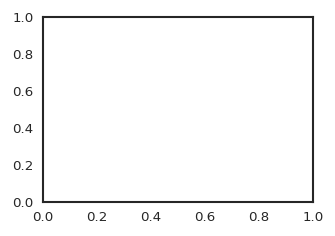

In [ ]:
if isnotebook():
    import matplotlib
    import matplotlib.pyplot as plt
    import seaborn as sns

    from matplotlib.ticker import FormatStrFormatter
    from labm8 import viz

    # Plotting configuration
    %matplotlib inline
    sns.set(style="ticks", color_codes=True)
    plt.style.use(["seaborn-white", "seaborn-paper"])
    matplotlib.rcParams['figure.dpi'] = 120

    for i, platform in enumerate(["AMD Radeon HD 5900", "AMD Tahiti 7970", "NVIDIA GTX 480", "NVIDIA Tesla K20c"]):

        def get_speedups(df, platform):
            """ get % accuracies for platform, aggregated by benchmark suite """
            r = df[df["Platform"] == platform]
            d = pd.DataFrame(r["Speedup"].values, columns=['Speedup'], index=r['Kernel'])
            avg = pd.Series([d.mean(),], index=["Speedup"], name="Average")
            return d.append(avg)

        # Aggregate data
        # models, results = (Magni, DeepTune, DeepTune_TL), (magni, deeptune, deeptune_tl)
        models, results = (DeepTune, DeepTune_TL), (deeptune, deeptune_tl)
        dfs = [get_speedups(r, platform) for r in results]

        speedups    = np.concatenate([dfs[i]['Speedup'].values for i in range(len(dfs))])
        kernels     = np.concatenate([dfs[i].index.values for i in range(len(dfs))])
        model_names = np.concatenate([np.array([m().__name__] * len(dfs[0])) for m in models])

        df = pd.DataFrame([{"Kernel": k, "Speedup": s - 1, "Model": m}
                           for k, s, m in zip(kernels, speedups, model_names)])

        # Plot
        palette = sns.cubehelix_palette(2, rot=.5, light=.85, dark=.35)
        plt.subplot(2, 2, i+1)
        ax = sns.barplot(x="Kernel", y="Speedup", hue="Model", palette=palette, data=df)
        plt.title(platform)

        # y axis
        plt.axhline(y=0, color="k", lw=.5)
        plt.ylim((-1, 1.5))
        ax.set_yticklabels(["{:.1f}x".format(float(i) + 1.0) for i in ax.get_yticks()])  # negative offset
        if i % 2:
            plt.ylabel("")  
        else:
            plt.ylabel("Speedup")

        # x axis
        plt.setp(ax.get_xticklabels(), rotation=90)  # rotate x ticks
        plt.xlabel("")
        plt.axvline(x=plt.xlim()[1] - 1, color="k", lw=1, linestyle="--")  # average line

        # legend
        ax.get_legend().set_title("")
        plt.legend(loc='upper left', ncol=1)    
        ax.get_legend().draw_frame(True)

    viz.finalise(figsize=(9, 7))

Geometric means:

In [ ]:
from labm8 import math as labmath

# magni_geomean = labmath.geomean(magni['Speedup'].values)
deeptune_geomean = labmath.geomean(deeptune['Speedup'].values)
deeptune_tl_geomean = labmath.geomean(deeptune_tl['Speedup'].values)

# print(f"Geometric mean of Magni et al. {magni_geomean:.2f}x")
print(f"Geometric mean of DeepTune {deeptune_geomean:.2f}x")
print(f"Geometric mean of DeepTune-TL {deeptune_tl_geomean:.2f}x")

Geometric mean of DeepTune 1.27x
Geometric mean of DeepTune-TL 1.17x


### 4.2. Influence of Transfer Learning

In [ ]:
dt_platform_speedups = deeptune.groupby("Platform").mean()["Speedup"].iteritems()
dt_tl_platform_speedups = deeptune_tl.groupby("Platform").mean()["Speedup"].iteritems()

num_improvements = 0
tl_speedups = []
for (platform, speedup), (_, speedup_tl) in zip(dt_platform_speedups, dt_tl_platform_speedups):
    if speedup_tl > speedup:
        num_improvements += 1
    tl_speedup = (speedup_tl / speedup) - 1
    tl_speedups.append({"Platform": platform, "TL-speedup": tl_speedup})

max_tl_speedup = max(tl_speedups, key=lambda x: x["TL-speedup"])
print(f"Transfer Learning improved performance on {num_improvements} of the 4 platforms")
print("The greatest per-platform performance improvement was "
      f"{max_tl_speedup['TL-speedup']:.1%} on {max_tl_speedup['Platform']}")

Transfer Learning improved performance on 0 of the 4 platforms
The greatest per-platform performance improvement was 0.0% on AMD Radeon HD 5900


### 4.3. Comparison to State-of-the-art

In [ ]:
deeptune_speedup = deeptune["Speedup"].mean()
deeptune_tl_speedup = deeptune_tl["Speedup"].mean()
# magni_speedup = magni["Speedup"].mean()

# performance_improvement = (deeptune_speedup / magni_speedup) - 1
# performance_improvement_tl = (deeptune_tl_speedup / magni_speedup) - 1

performance_improvement = (deeptune_speedup / deeptune_speedup) - 1
performance_improvement_tl = (deeptune_tl_speedup / deeptune_speedup) - 1

print(f"DeepTune outperforms state-of-the-art by {performance_improvement:.0%}")
print(f"DeepTune-TL outperforms state-of-the-art by {performance_improvement_tl:.0%}")

DeepTune outperforms state-of-the-art by 0%
DeepTune-TL outperforms state-of-the-art by -7%


In [ ]:
num_cases = len(deeptune_tl)
# num_better = sum(1 for d, m in zip(deeptune_tl["Speedup"], magni["Speedup"]) if d >= m)
num_better = sum(1 for d, m in zip(deeptune_tl["Speedup"], deeptune["Speedup"]) if d >= m)
ratio_better = num_better / num_cases
print("DeepTune-TL matched or improved performance of state-of-the-art in "
      f"{num_better} of {num_cases} cases ({ratio_better:.1%})")

DeepTune-TL matched or improved performance of state-of-the-art in 3 of 4 cases (75.0%)


End of experiments.